# **Part 1 - Data Selection, Visualization, and Introduction**

**Data Selection**

We have taken a dataset on averzge electric power consumption in Germany, in years 2006-2017. The dataset contains records taken every day, with each entry including the exact date and power consumption measurements (in gWH).


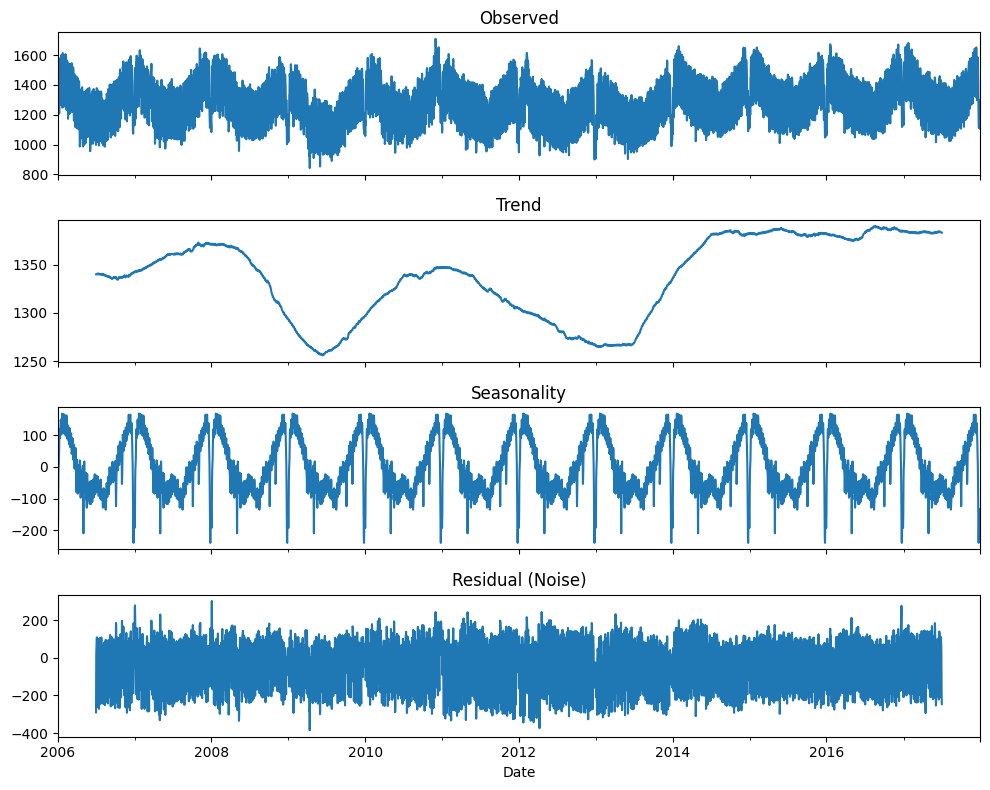

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

file_name = 'opsd_germany_daily.csv'
data = pd.read_csv(file_name)

data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.set_index('Date', inplace=True)

series = data['Consumption']
decomposition = seasonal_decompose(series, model='additive', period=365)

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], title='Observed', legend=False)
decomposition.trend.plot(ax=axes[1], title='Trend', legend=False)
decomposition.seasonal.plot(ax=axes[2], title='Seasonality', legend=False)
decomposition.resid.plot(ax=axes[3], title='Residual (Noise)', legend=False)

plt.tight_layout()
plt.show()


First, lets visualize different columns in the data:

In [16]:
import plotly.graph_objects as go
import plotly.express as px

data['Day'] = data.index.day_name()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
color_palette = px.colors.sequential.Plasma_r  # Color palette for bars
avg_consumption_by_day = data.groupby('Day')['Consumption'].mean().reindex(day_order)


fig = go.Figure(go.Bar(
    x=avg_consumption_by_day.index,  # Day of the week
    y=avg_consumption_by_day.values,  # Average consumption
    marker=dict(color=color_palette[:len(avg_consumption_by_day)]),  # Apply color palette
))

fig.update_layout(
    title="Average Power Consumption Across Days of the Week",
    xaxis_title="Day of the Week",
    yaxis_title="Average Power Consumption (GWh)",
    xaxis=dict(tickangle=0),  # Angle of the day names
    yaxis=dict(tickformat=".2f"),  # Show y-axis with 2 decimal points
    hovermode="closest"
)

fig.show()


In [17]:
# Define the correct order for days in Germany
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
color = '#1f77b4'

fig = go.Figure()
for day in week_order:
    df_day = data[data['Day'] == day]
    fig.add_trace(go.Box(
        y=df_day['Consumption'],
        name=day,
        boxmean=True,
        line=dict(width=1),
        marker=dict(color=color)
    ))

fig.update_layout(
    title="Power Consumption Box Plot by Day of the Week",
    xaxis_title="Day of the Week",
    yaxis_title="Power Consumption (GWh)",
    xaxis=dict(categoryorder='array', categoryarray=week_order, tickangle=-45),
    showlegend=False
)

fig.show()


We can see weekdays trends look very similar, and on weekends (which are Saturday and Sunday in Germany) the power consumption decreases.

In [18]:
data['Month'] = data.index.month_name()

season_colors = {
    'Winter': 'rgb(26, 117, 255)',
    'Spring': 'rgb(31, 122, 31)',
    'Summer': 'rgb(255, 51, 51)',
    'Autumn': 'rgb(179, 107, 0)'
}

# Map month names to seasons
season_mapping = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Autumn', 'October': 'Autumn', 'November': 'Autumn'
}
data['Season'] = data['Month'].map(season_mapping)

# Define month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']


# Create the figure
fig = go.Figure()

# Add boxplot traces for each month in correct order
for month in month_order:
    df_month = data[data['Month'] == month]
    season = season_mapping[month]
    color = season_colors[season]

    fig.add_trace(go.Box(
        y=df_month['Consumption'],
        name=month,
        boxmean=True,
        marker_color=color,
        showlegend=False,
        line=dict(width=1),
        legendgroup=season
    ))

# Add dummy scatter traces to create a season-based legend
for season, color in season_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(color=color, size=10),
        name=season,
        showlegend=True
    ))

# Update layout
fig.update_layout(
    title="Power Consumption by Month",
    xaxis_title="Month",
    yaxis_title="Power Consumption (GWh)",
    xaxis=dict(tickangle=-45),
    showlegend=True
)

# Show the plot
fig.show()


In [19]:
import numpy as np

data['Year'] = data.index.year
annual_consumption = data.groupby('Year')['Consumption'].sum().reset_index()

x = annual_consumption['Year']
y = annual_consumption['Consumption']
coeffs = np.polyfit(x, y, deg=1)
trendline = coeffs[0] * x + coeffs[1]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=x,
    y=y,
    text=y.round(2),
    textposition='outside',
    name='Annual Consumption'
))

fig.add_trace(go.Scatter(
    x=x,
    y=trendline,
    mode='lines',
    name='Trend Line',
    line=dict(color='firebrick', width=2, dash='dash')
))

fig.update_layout(
    title="Annual Power Consumption Trend with Regression Line",
    xaxis_title="Year",
    yaxis_title="Total Power Consumption (GWh)",
    showlegend=True
)

fig.show()


In [20]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(data['Consumption'])

adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

# Interpretation
if p_value < 0.05:
    print("The time series is likely stationary (reject the null hypothesis).")
else:
    print("The time series is likely non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -6.239148288864479
p-value: 4.7440549018425884e-08
Critical Values:
  1%: -3.4318538295011636
  5%: -2.8622045082106773
  10%: -2.5671237222704466
The time series is likely stationary (reject the null hypothesis).


In [21]:
# Winter Zoom-In

# Filter data for October-December 2010 and January-March 2011
data_oct_dec_2010 = data[(data.index.year == 2010) & (data.index.month.isin([10, 11, 12]))]
data_jan_march_2011 = data[(data.index.year == 2011) & (data.index.month.isin([1, 2, 3]))]

# Combine the two periods into one DataFrame
data_filtered = pd.concat([data_oct_dec_2010, data_jan_march_2011])


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data_filtered.index,
    y=data_filtered['Consumption'],
    mode='lines',
    name='Power Consumption',
    line=dict(color='blue')
))

fig.update_layout(
    title="Power Consumption Winter Zoom-In",
    xaxis_title="Date",
    yaxis_title="Power Consumption (GWh)",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show()


# **Part 2 - Models**

## Preparing Data

In [22]:
# Plot all data
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['Consumption'],
    mode='lines',
    name='Power Consumption',
    line=dict(color='blue')
))

fig.update_layout(
    title="Power Consumption in Germany, 2006-2017",
    xaxis_title="Date",
    yaxis_title="Power Consumption (GWh)",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show()

In [23]:
# Resample to weekly frequency (taking the mean consumption per week)
weekly_series = data['Consumption'].resample('W').mean()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_series.index,
    y=weekly_series,
    mode='lines',
    name='Weekly Power Consumption',
    line=dict(color='blue')
))
fig.update_layout(
    title="Weekly Power Consumption Trend (2006-2017)",
    xaxis_title="Date",
    yaxis_title="Power Consumption (GWh)",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)
fig.show()

In [24]:
from sklearn.model_selection import train_test_split

data = data[['Consumption']]

# Split the data into train and test sets (80% train, 20% test)
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Identify the point where the split happens (the last index of the train set)
split_point = train_data.index[-1]

# Plotting
fig = go.Figure()

# Plot the train data (80%)
fig.add_trace(go.Scatter(
    x=train_data.index,
    y=train_data['Consumption'],
    mode='lines',
    name='Train Data',
    line=dict(color='blue')  # Blue line for train data
))

# Plot the test data (20%)
fig.add_trace(go.Scatter(
    x=test_data.index,
    y=test_data['Consumption'],
    mode='lines',
    name='Test Data',
    line=dict(color='red')  # Red line for test data
))

# Add a vertical dashed line at the split point
fig.add_vline(
    x=split_point,
    line=dict(color="black", dash="dash", width=2),
    name="Train-Test Split"
)

# Update layout
fig.update_layout(
    title="Train-Test Split (80/20) - Daily",
    xaxis_title="Date",
    yaxis_title="Power Consumption (GWh)",
    hovermode="x unified"
)

fig.show()


In [25]:
# Splitting Weekly data also
train_size = int(len(weekly_series) * 0.8)  # 80% train
train_weekly, test_weekly = train_test_split(weekly_series, test_size=0.2, shuffle=False)
train_weekly.index = pd.to_datetime(train_weekly.index)
test_weekly.index = pd.to_datetime(test_weekly.index)

In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train_weekly.index,
    y=train_weekly,
    mode='lines',
    name='Train Data',
    line=dict(color='blue')  # Blue line for train data
))

fig.add_trace(go.Scatter(
    x=test_weekly.index,
    y=test_weekly,
    mode='lines',
    name='Test Data',
    line=dict(color='red')  # Red line for test data
))

split_point = train_weekly.index[-1]
fig.add_vline(
    x=split_point,
    line=dict(color="black", dash="dash", width=2),
    name="Train-Test Split"
)

fig.update_layout(
    title="Train-Test Split (80/20) - Weekly",
    xaxis_title="Date",
    yaxis_title="Power Consumption (GWh)",
    hovermode="x unified"
)

fig.show()


## Baseline Model

In [27]:
from sklearn.metrics import mean_squared_error
# Baseline - daily model
# Extract 'month-day' (e.g., "03-20" for March 20)
train_data['month_day'] = train_data.index.strftime('%m-%d')
test_data['month_day'] = test_data.index.strftime('%m-%d')

# Compute the average consumption for each month-day
daily_profile = train_data.groupby('month_day')['Consumption'].mean().reset_index()
# The prediction =  mean of the same calendar day in the train set
test_merged = test_data.merge(daily_profile, on='month_day', how='left', suffixes=('_actual', '_predicted'))
test_merged.index = test_data.index

rmse = np.sqrt(mean_squared_error(test_merged['Consumption_actual'], test_merged['Consumption_predicted']))
print(f"Baseline RMSE (Same Calendar Day Mean): {rmse:.2f}")

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['Consumption'],
    mode='lines',
    name='Actual Data',
    line=dict(color='blue')
))


fig.add_trace(go.Scatter(
    x=test_merged.index,
    y=test_merged['Consumption_predicted'],
    mode='lines',
    name='Predicted Test Data',
    line=dict(color='red', dash='dash')
))

fig.add_trace(go.Scatter(
    x=[test_data.index[0], test_data.index[0]],
    y=[800,1700],
    mode='lines',
    name='Train/Test Split',
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    title="Baseline Model - Daily Actual vs. Predicted Consumption",
    xaxis_title="Date",
    yaxis_title="Consumption",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

fig.show()


Baseline RMSE (Same Calendar Day Mean): 149.65


In [28]:
train_weekly_df = train_weekly.to_frame(name='Consumption')  # or use a better name for your data
test_weekly_df = test_weekly.to_frame(name='Consumption')

train_weekly_df['month'] = train_weekly_df.index.month
train_weekly_df['week'] = train_weekly_df.index.isocalendar().week

test_weekly_df['month'] = test_weekly_df.index.month
test_weekly_df['week'] = test_weekly_df.index.isocalendar().week


# Compute the average consumption for each (month, week)
weekly_profile = (
    train_weekly_df.groupby(['month', 'week'])['Consumption']
    .mean()
    .reset_index()
)

test_merged = test_weekly_df.merge(weekly_profile, on=['month', 'week'], suffixes=('_actual', '_predicted'))
test_merged.index = test_weekly.index

rmse = np.sqrt(mean_squared_error(test_merged['Consumption_actual'], test_merged['Consumption_predicted']))
print(f"Baseline RMSE (Same Week Average): {rmse:.2f}")

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_series.index,
    y=weekly_series,
    mode='lines',
    name='Actual Data',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=test_merged.index,
    y=test_merged['Consumption_predicted'],
    mode='lines',
    name='Predicted Test Data',
    line=dict(color='red', dash='dash')
))

fig.add_trace(go.Scatter(
    x=[test_weekly.index[0], test_weekly.index[0]],
    y=[test_merged['Consumption_actual'].min(), test_merged['Consumption_actual'].max()],
    mode='lines',
    name='Train/Test Split',
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    title="Baseline Model - Weekly Actual vs. Predicted Consumption",
    xaxis_title="Date",
    yaxis_title="Consumption",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

fig.show()


Baseline RMSE (Same Week Average): 61.78


## SARIMA

In [29]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print("ADF Test Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])

    if result[1] <= 0.05:
        print("✅ The series is stationary.")
    else:
        print("❌ The series is NOT stationary. Differencing is needed.")

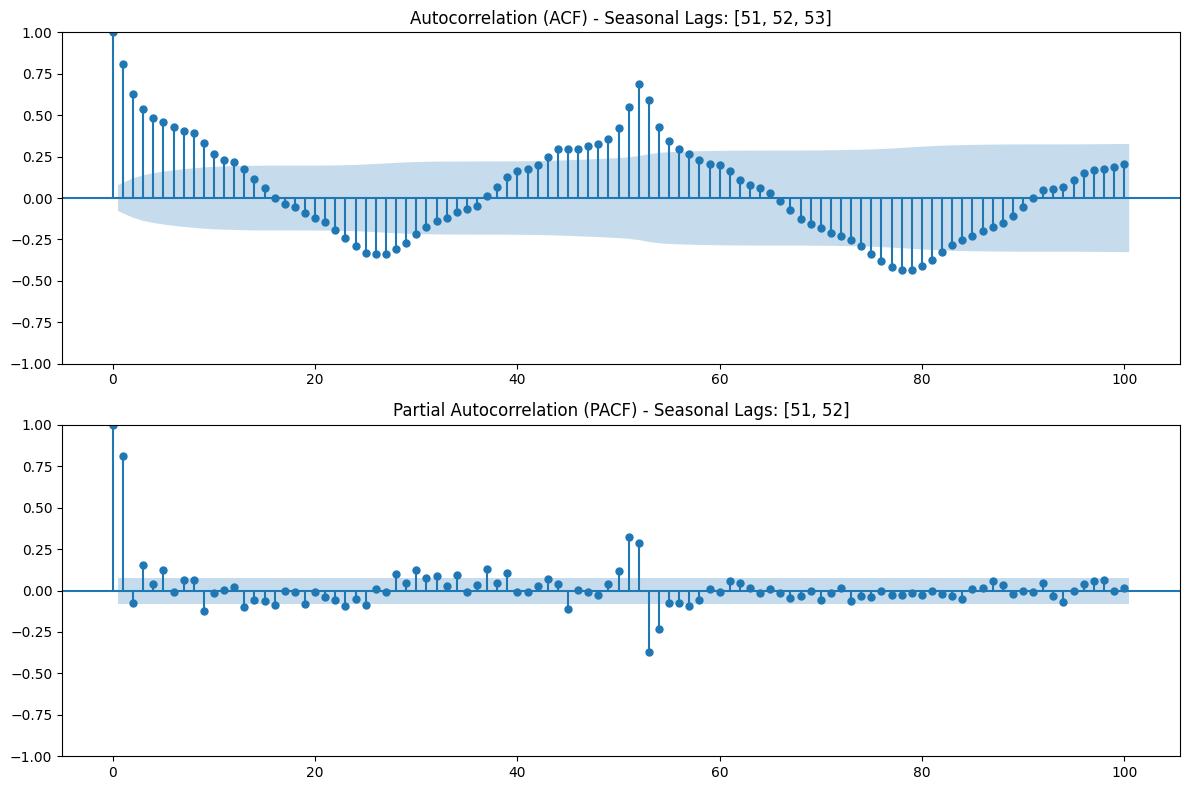

Detected seasonal lag in ACF: [51, 52, 53]
Detected seasonal lag in PACF: [51, 52]


In [30]:
import statsmodels.api as sm

lags = 100
acf_values = sm.tsa.acf(weekly_series, nlags=lags)
pacf_values = sm.tsa.pacf(weekly_series, nlags=lags)

# Find the first significant peak after lag 0
def find_seasonal_lag(acf_values, threshold):
    big_lags = []
    for i in range(4, len(acf_values)):  # Skip lag 0
        if acf_values[i] > threshold:  # Threshold for significance (adjust if needed)
            big_lags.append(i)
    return big_lags

seasonal_lag_acf = find_seasonal_lag(acf_values, 0.5)
seasonal_lag_pacf = find_seasonal_lag(pacf_values, 0.25)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(weekly_series, lags=lags, ax=ax[0])
ax[0].set_title(f"Autocorrelation (ACF) - Seasonal Lags: {seasonal_lag_acf}")

sm.graphics.tsa.plot_pacf(weekly_series, lags=lags, ax=ax[1])
ax[1].set_title(f"Partial Autocorrelation (PACF) - Seasonal Lags: {seasonal_lag_pacf}")

plt.tight_layout()
plt.show()

# Print the detected seasonal lags
print(f"Detected seasonal lag in ACF: {seasonal_lag_acf}")
print(f"Detected seasonal lag in PACF: {seasonal_lag_pacf}")


The ADF test said the series was stationary, but the graphs made us think we could still use differencing.

ADF Test Statistic: -5.755044641203834
p-value: 5.846193952156476e-07
Critical Values: {'1%': np.float64(-3.4410979308822967), '5%': np.float64(-2.8662819588823423), '10%': np.float64(-2.5692953639629166)}
✅ The series is stationary.


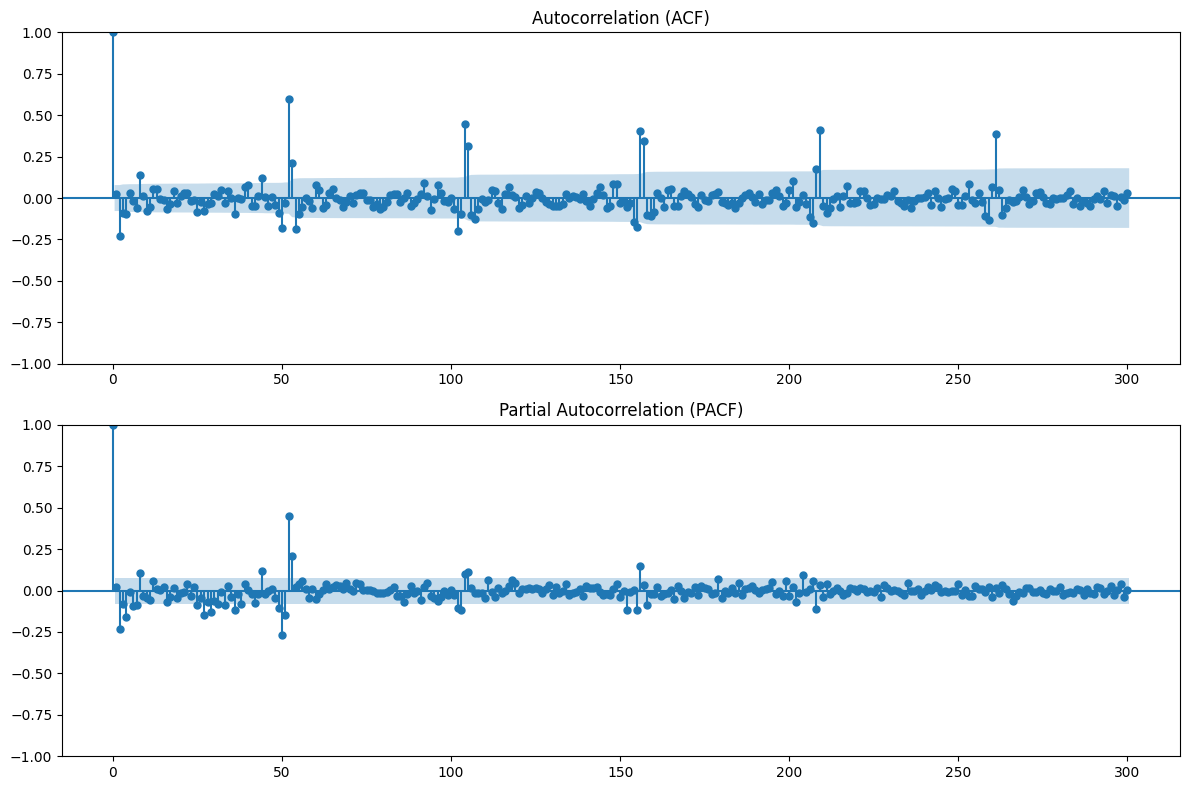

Detected seasonal lag in ACF: [52]
Detected seasonal lag in PACF: [52, 53, 169, 170, 171, 172, 175, 179, 180, 181, 182, 207, 214, 220, 221, 224, 225, 231, 261, 267, 268, 270, 271, 274, 276, 277, 280, 283, 284, 288, 291, 292, 295, 296, 297, 298, 300]


In [31]:
weekly_diff = weekly_series.diff().dropna()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=weekly_diff.index,
    y=weekly_diff,
    mode='lines',
    name='Weekly Power Consumption',
    line=dict(color='blue')
))


fig.update_layout(
    title="Weekly Differencing of Power Consumption",
    xaxis_title="Date",
    yaxis_title="Power Consumption (GWh)",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)
fig.show()

check_stationarity(weekly_series)

lags = 300  # Number of lags to compute
acf_values = sm.tsa.acf(weekly_diff, nlags=lags)
pacf_values = sm.tsa.pacf(weekly_diff, nlags=lags)

# Find the first significant peak after lag 0
def find_seasonal_lag(acf_values, threshold):
    big_lags = []
    for i in range(4, len(acf_values)):  # Skip lag 0
        if acf_values[i] > threshold:  # Threshold for significance (adjust if needed)
            big_lags.append(i)
    return big_lags

seasonal_lag_acf = find_seasonal_lag(acf_values, 0.5)
seasonal_lag_pacf = find_seasonal_lag(pacf_values, 0.25)

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
sm.graphics.tsa.plot_acf(weekly_diff, lags=lags, ax=ax[0])
ax[0].set_title(f"Autocorrelation (ACF)")

# PACF plot
sm.graphics.tsa.plot_pacf(weekly_diff, lags=lags, ax=ax[1])
ax[1].set_title(f"Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

# Print the detected seasonal lags
print(f"Detected seasonal lag in ACF: {seasonal_lag_acf}")
print(f"Detected seasonal lag in PACF: {seasonal_lag_pacf}")


ADF Test Statistic: -14.328954633415309
p-value: 1.1082653589367894e-26
Critical Values: {'1%': np.float64(-3.441935806025943), '5%': np.float64(-2.8666509204896093), '10%': np.float64(-2.5694919649816947)}
✅ The series is stationary.


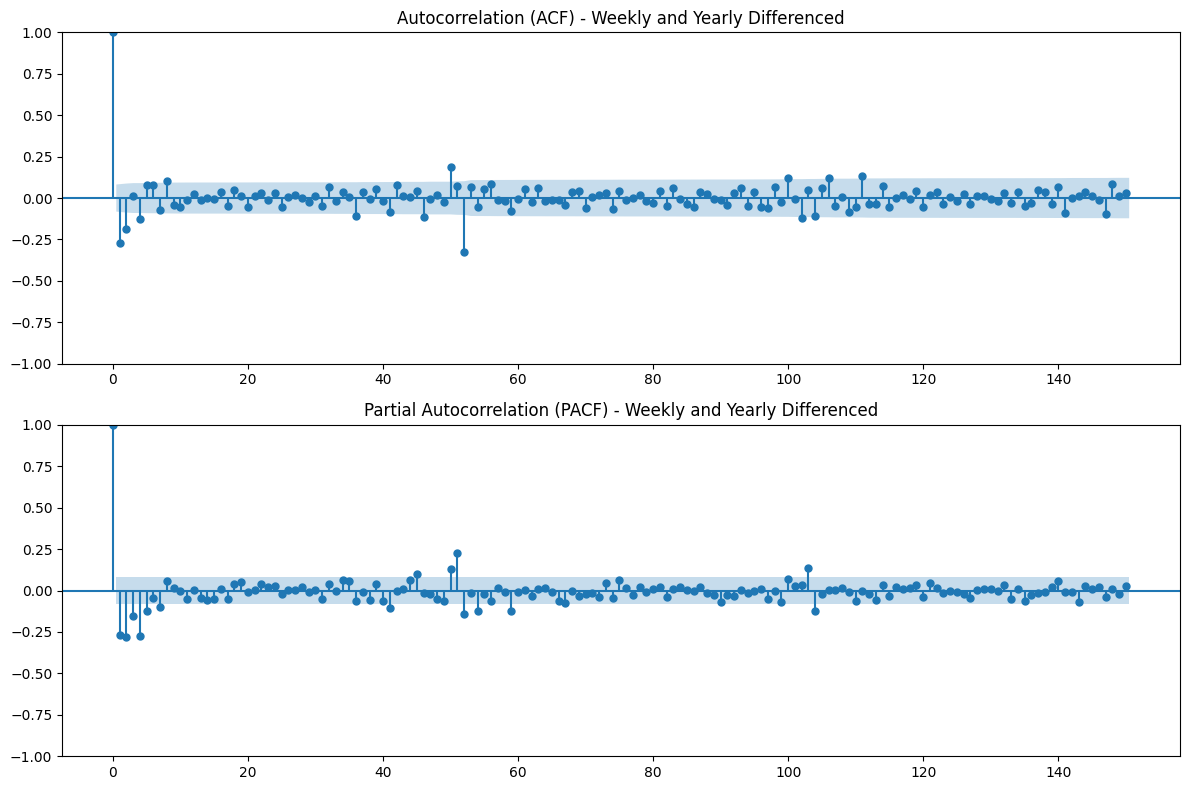

Detected seasonal lag in ACF after both differences: []
Detected seasonal lag in PACF after both differences: [51]


In [32]:
weekly_diff = weekly_series.diff().dropna()
weekly_yearly_diff = weekly_diff.diff(52).dropna()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=weekly_yearly_diff.index,
    y=weekly_yearly_diff,
    mode='lines',
    name='Weekly and Yearly Differenced Power Consumption',
    line=dict(color='blue')
))

fig.update_layout(
    title="Weekly and Yearly Differencing of Power Consumption",
    xaxis_title="Date",
    yaxis_title="Power Consumption (GWh)",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)
fig.show()

check_stationarity(weekly_yearly_diff)

lags = 150
acf_values = sm.tsa.acf(weekly_yearly_diff, nlags=lags)
pacf_values = sm.tsa.pacf(weekly_yearly_diff, nlags=lags)

seasonal_lag_acf = find_seasonal_lag(acf_values, 0.2)  # Adjusted threshold
seasonal_lag_pacf = find_seasonal_lag(pacf_values, 0.2)

# Plot ACF and PACF for the double-differenced series
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(weekly_yearly_diff, lags=lags, ax=ax[0])
ax[0].set_title("Autocorrelation (ACF) - Weekly and Yearly Differenced")

sm.graphics.tsa.plot_pacf(weekly_yearly_diff, lags=lags, ax=ax[1])
ax[1].set_title("Partial Autocorrelation (PACF) - Weekly and Yearly Differenced")

plt.tight_layout()
plt.show()

print(f"Detected seasonal lag in ACF after both differences: {seasonal_lag_acf}")
print(f"Detected seasonal lag in PACF after both differences: {seasonal_lag_pacf}")

Trying SARIMA (1, 1, 1) (1, 1, 1, 52)...
                                     SARIMAX Results                                      
Dep. Variable:                        Consumption   No. Observations:                  501
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -2021.326
Date:                            Sun, 06 Apr 2025   AIC                           4052.652
Time:                                    19:13:41   BIC                           4072.534
Sample:                                01-01-2006   HQIC                          4060.531
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3680      0.055      6.734      0.000       0.261       

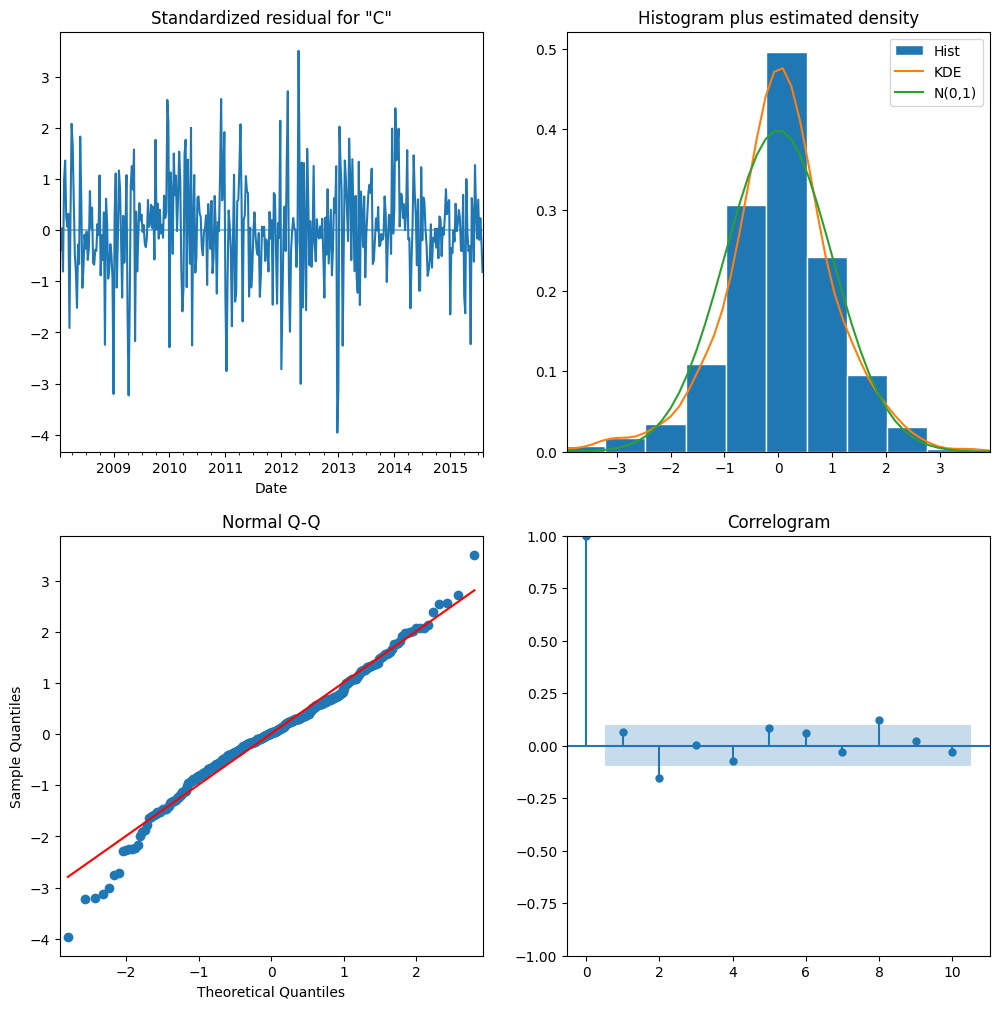

Trying SARIMA (1, 1, 1) (1, 1, 2, 52)...
                                        SARIMAX Results                                        
Dep. Variable:                             Consumption   No. Observations:                  501
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 52)   Log Likelihood               -1757.397
Date:                                 Sun, 06 Apr 2025   AIC                           3526.793
Time:                                         19:16:01   BIC                           3549.802
Sample:                                     01-01-2006   HQIC                          3535.960
                                          - 08-02-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3677      0.059 

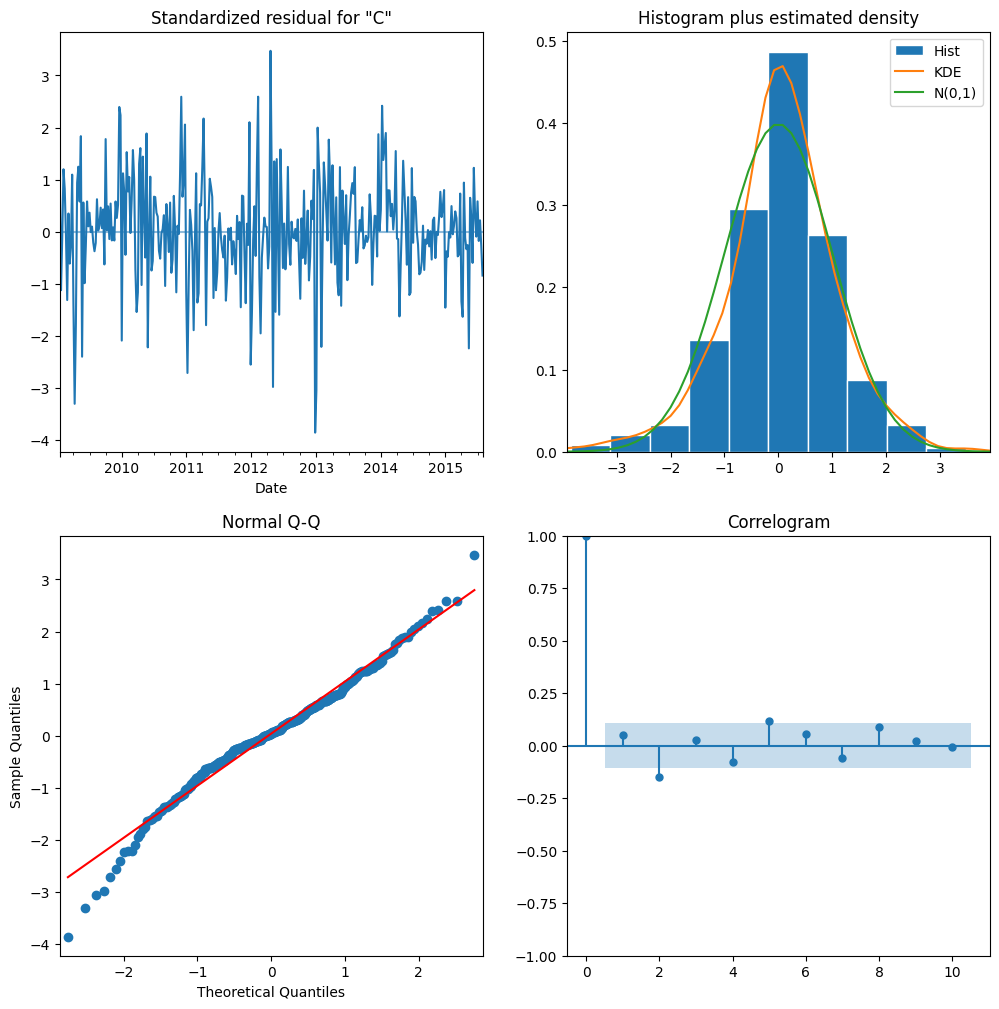

Trying SARIMA (1, 1, 1) (2, 1, 2, 52)...
                                        SARIMAX Results                                        
Dep. Variable:                             Consumption   No. Observations:                  501
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 52)   Log Likelihood               -1735.149
Date:                                 Sun, 06 Apr 2025   AIC                           3484.299
Time:                                         19:18:36   BIC                           3511.142
Sample:                                     01-01-2006   HQIC                          3494.992
                                          - 08-02-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4406      0.062 

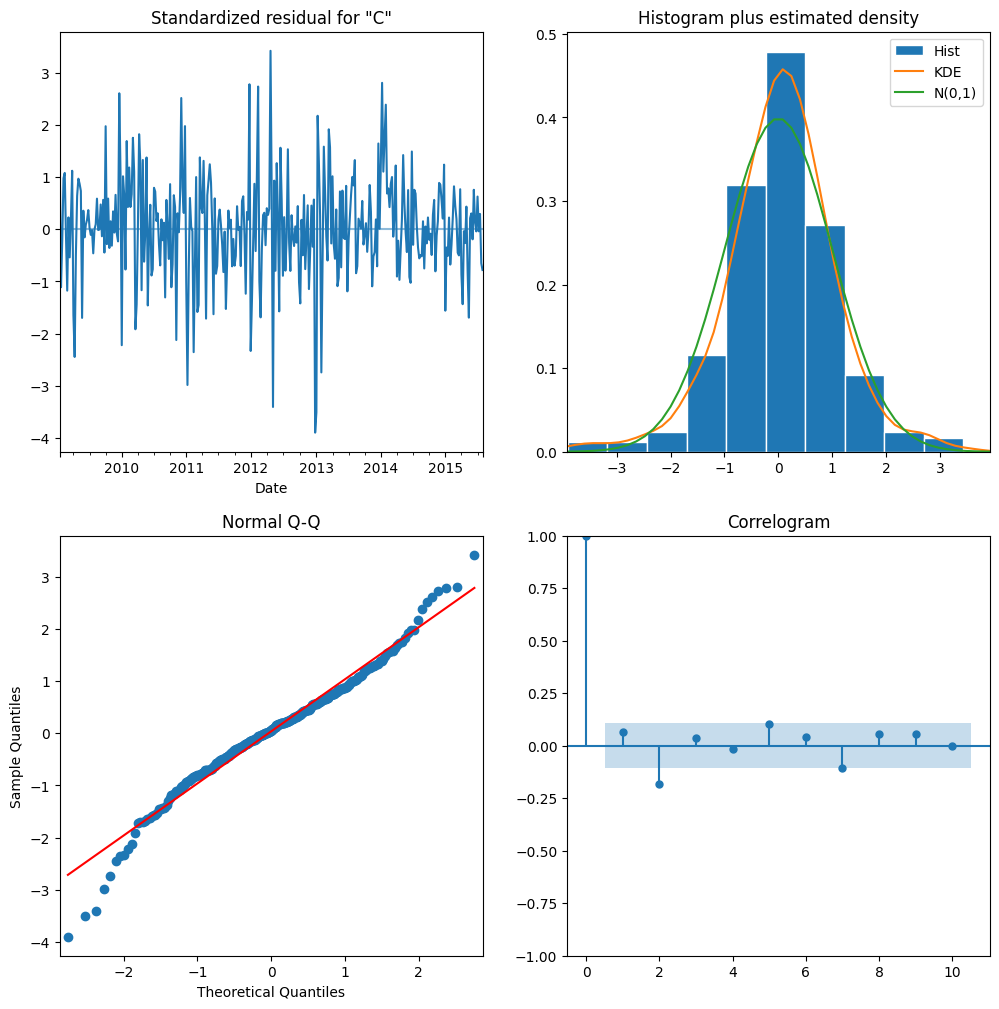

Trying SARIMA (1, 1, 1) (2, 1, 1, 52)...
                                     SARIMAX Results                                      
Dep. Variable:                        Consumption   No. Observations:                  501
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 52)   Log Likelihood               -1744.180
Date:                            Sun, 06 Apr 2025   AIC                           3500.361
Time:                                    19:20:49   BIC                           3523.387
Sample:                                01-01-2006   HQIC                          3509.533
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4077      0.060      6.794      0.000       0.290       

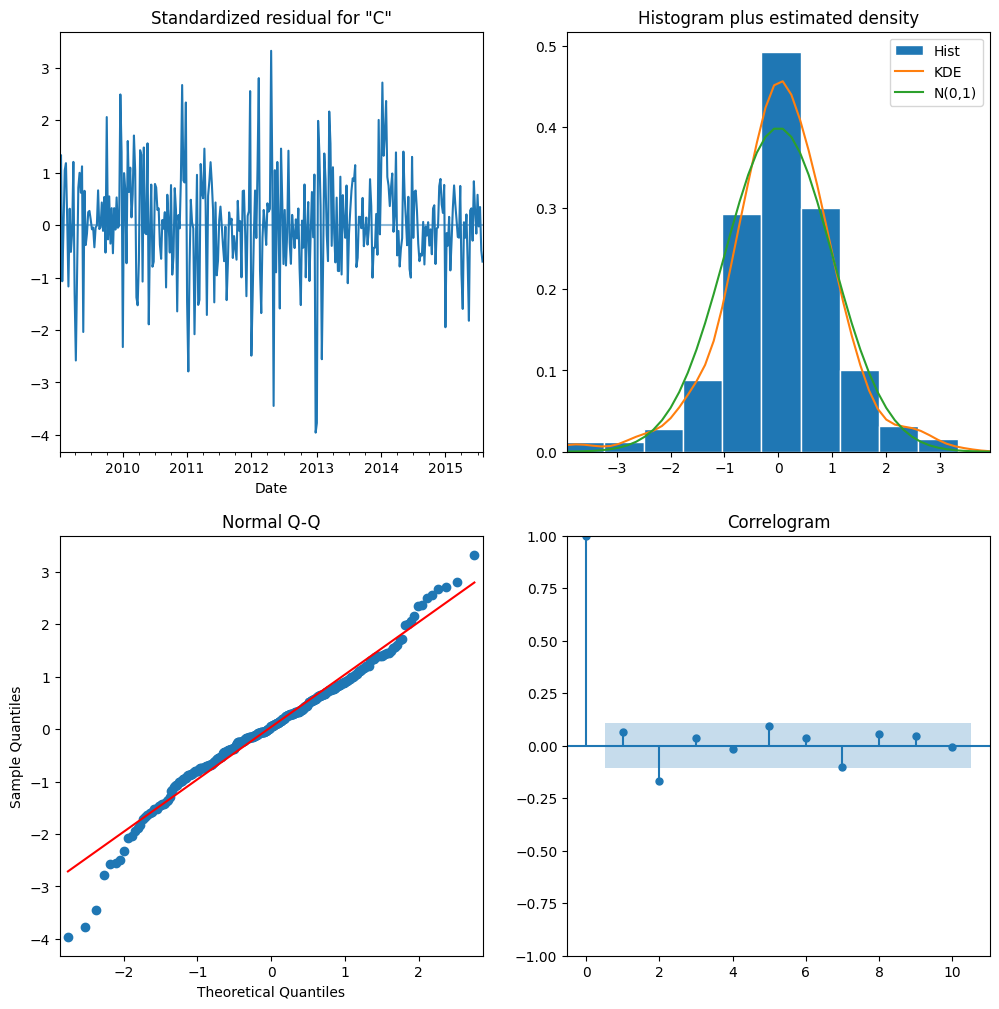

Best model is SARIMA (1, 1, 1) (2, 1, 2, 52), BIC = 3511.1422097728127


In [33]:
# Trying SARIMAs with d=1, D=1 (weekly and yearly differencing)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
min_bic = 10000
seas_orders = [(1, 1, 1, 52), (1, 1, 2, 52), (2, 1, 2, 52), (2, 1, 1, 52)]

for o in seas_orders:
  print(f'Trying SARIMA (1, 1, 1) {o}...')
  model = SARIMAX(train_weekly,
                  order=(1, 1, 1),              # Non-seasonal components (p,d,q)
                  seasonal_order=o,
                  enforce_stationarity=False,
                  enforce_invertibility=False)
  results = model.fit(disp=False)
  bic = results.bic
  if bic<min_bic:
    min_bic = bic
    best_seasonal_order = o
  print(results.summary())
  # Plot diagnostics
  results.plot_diagnostics(figsize=(12, 12))
  plt.show()
print(f'Best model is SARIMA (1, 1, 1) {best_seasonal_order}, BIC = {min_bic}')

In [34]:
# Results with D=1
from sklearn.metrics import mean_squared_error
model = SARIMAX(train_weekly,
                  order=(1, 1, 1),
                  seasonal_order=(2, 1, 2, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
results = model.fit(disp=False)

test_steps = len(test_weekly)
sarima_test_forecast = results.get_forecast(steps=test_steps)
test_ci = sarima_test_forecast.conf_int()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_series.index,
    y=weekly_series,
    mode='lines',
    name='Actual',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=test_weekly.index,
    y=sarima_test_forecast.predicted_mean,
    mode='lines',
    name='Test Forecast',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=test_ci.index,
    y=test_ci.iloc[:, 1],  # Upper bound
    mode='lines',
    line=dict(color='rgba(255,0,0,0.3)'),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=test_ci.index,
    y=test_ci.iloc[:, 0],  # Lower bound
    mode='lines',
    fill='tonexty',  # Fill between lower and upper
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,0,0,0.3)'),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=[test_weekly.index[0], test_weekly.index[0]],
    y=[weekly_series.min(), weekly_series.max()],
    mode='lines',
    name='Train/Test Split',
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    title="SARIMA Weekly - Forecast vs Actual",
    xaxis_title="Date",
    yaxis_title="Power Consumption (GWh)",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

fig.show()

rmse = np.sqrt(mean_squared_error(test_weekly, sarima_test_forecast.predicted_mean))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 73.6626


Trying SARIMA (1, 1, 1) (1, 0, 1, 52)...
                                     SARIMAX Results                                      
Dep. Variable:                        Consumption   No. Observations:                  501
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 52)   Log Likelihood               -2278.496
Date:                            Sun, 06 Apr 2025   AIC                           4566.991
Time:                                    19:23:37   BIC                           4587.493
Sample:                                01-01-2006   HQIC                          4575.075
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3624      0.053      6.860      0.000       0.259       

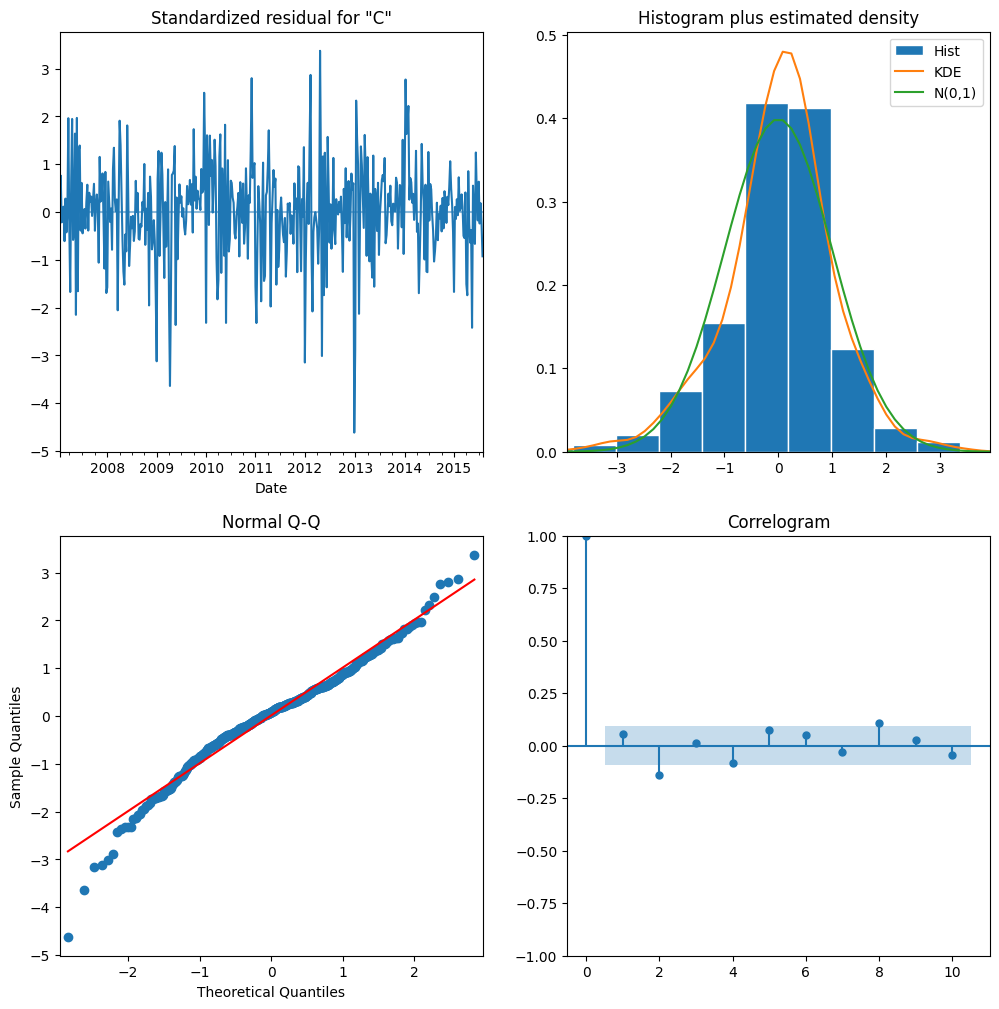

Trying SARIMA (1, 1, 1) (1, 0, 2, 52)...
                                        SARIMAX Results                                        
Dep. Variable:                             Consumption   No. Observations:                  501
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 52)   Log Likelihood               -2020.611
Date:                                 Sun, 06 Apr 2025   AIC                           4053.222
Time:                                         19:24:46   BIC                           4077.080
Sample:                                     01-01-2006   HQIC                          4062.675
                                          - 08-02-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4073      0.059 

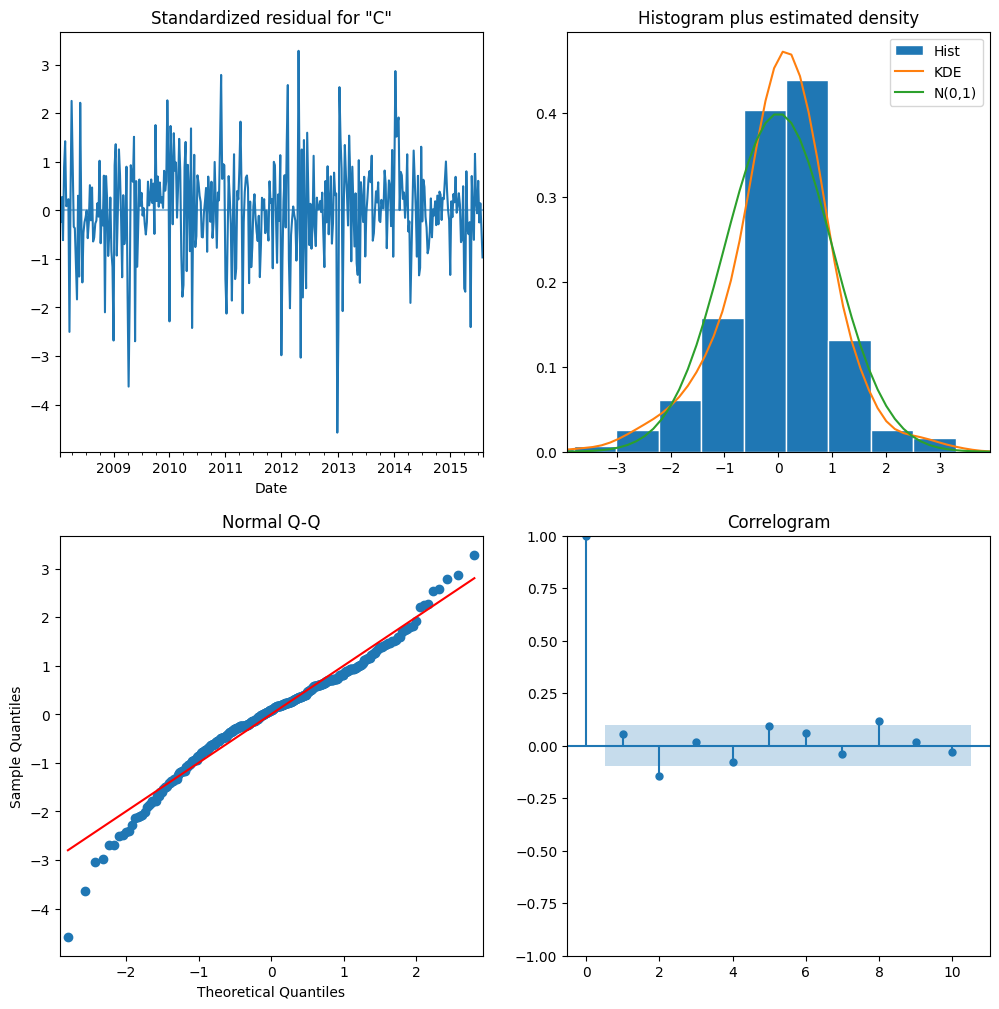

Trying SARIMA (1, 1, 1) (2, 0, 2, 52)...
                                        SARIMAX Results                                        
Dep. Variable:                             Consumption   No. Observations:                  501
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 52)   Log Likelihood               -2014.503
Date:                                 Sun, 06 Apr 2025   AIC                           4043.007
Time:                                         19:25:55   BIC                           4070.841
Sample:                                     01-01-2006   HQIC                          4054.036
                                          - 08-02-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4198      0.057 

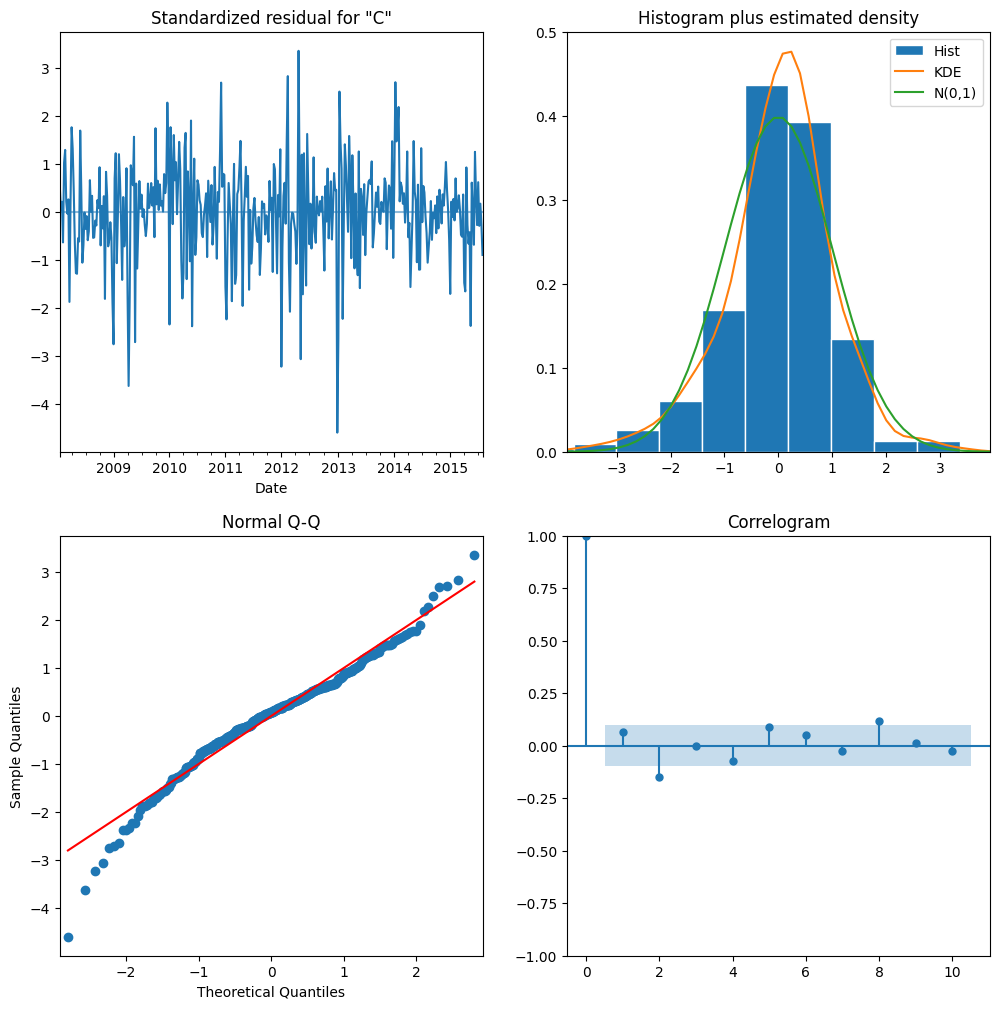

Trying SARIMA (1, 1, 1) (2, 0, 1, 52)...
                                     SARIMAX Results                                      
Dep. Variable:                        Consumption   No. Observations:                  501
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 52)   Log Likelihood               -2023.048
Date:                            Sun, 06 Apr 2025   AIC                           4058.096
Time:                                    19:26:49   BIC                           4081.969
Sample:                                01-01-2006   HQIC                          4067.555
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4042      0.058      6.912      0.000       0.290       

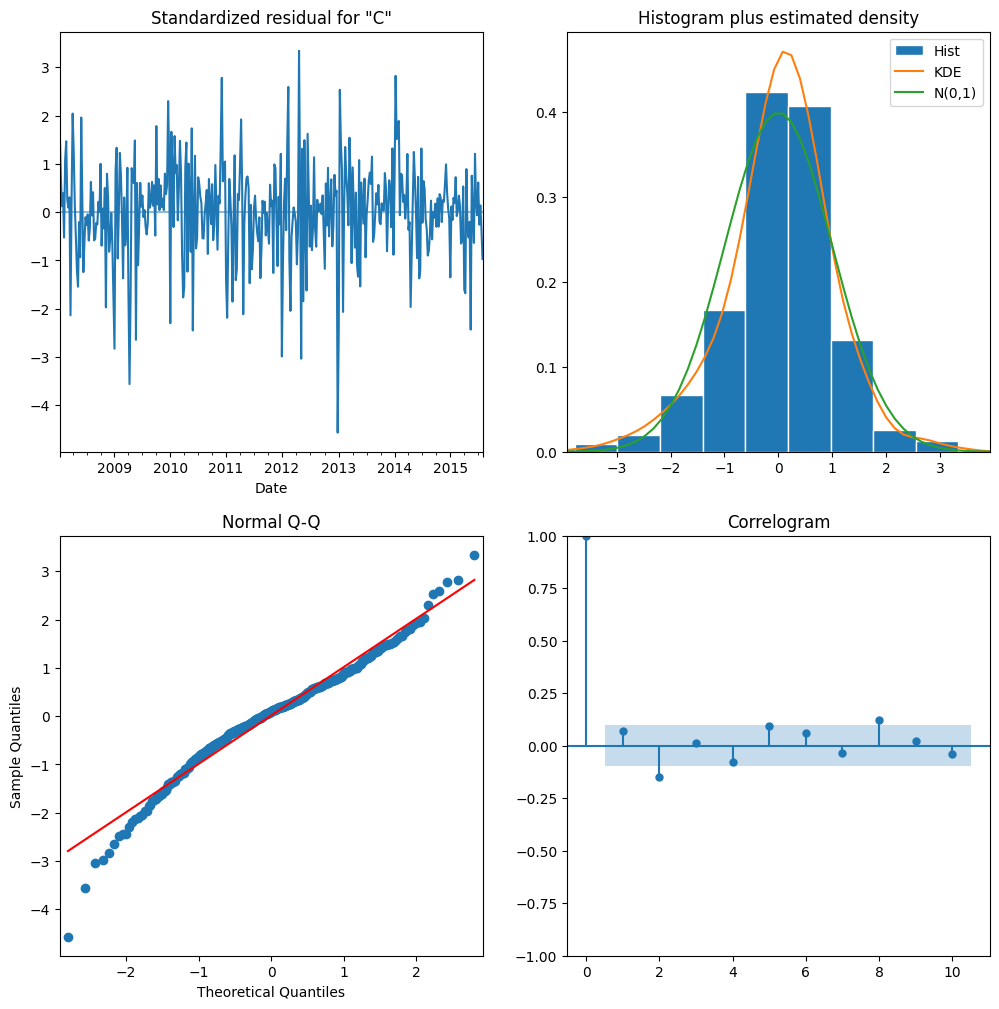

Best model is SARIMA (1, 1, 1) (2, 0, 2, 52), BIC = 4070.841121368091


In [35]:
# Trying SARIMAs with d=1, D=0 (weekly differencing only)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
min_bic = 10000
seas_orders = [(1, 0, 1, 52), (1, 0, 2, 52), (2, 0, 2, 52), (2, 0, 1, 52)]

for o in seas_orders:
  print(f'Trying SARIMA (1, 1, 1) {o}...')
  model = SARIMAX(train_weekly,
                  order=(1, 1, 1),              # Non-seasonal components (p,d,q)
                  seasonal_order=o,
                  enforce_stationarity=False,
                  enforce_invertibility=False)
  results = model.fit(disp=False)
  bic = results.bic
  if bic<min_bic:
    min_bic = bic
    best_seasonal_order = o
  print(results.summary())
  results.plot_diagnostics(figsize=(12, 12))
  plt.show()
print(f'Best model is SARIMA (1, 1, 1) {best_seasonal_order}, BIC = {min_bic}')

In [36]:
# Results with D=0
model = SARIMAX(train_weekly,
                  order=(1, 1, 1),
                  seasonal_order=(2, 0, 2, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
results = model.fit(disp=False)

test_steps = len(test_weekly)
sarima_test_forecast = results.get_forecast(steps=test_steps)
test_ci = sarima_test_forecast.conf_int()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_series.index,
    y=weekly_series,
    mode='lines',
    name='Actual',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=test_weekly.index,
    y=sarima_test_forecast.predicted_mean,
    mode='lines',
    name='Test Forecast',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=test_ci.index,
    y=test_ci.iloc[:, 1],  # Upper bound
    mode='lines',
    line=dict(color='rgba(255,0,0,0.3)'),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=test_ci.index,
    y=test_ci.iloc[:, 0],  # Lower bound
    mode='lines',
    fill='tonexty',  # Fill between lower and upper
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,0,0,0.3)'),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=[test_weekly.index[0], test_weekly.index[0]],
    y=[weekly_series.min(), weekly_series.max()],
    mode='lines',
    name='Train/Test Split',
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    title="SARIMA Weekly - Forecast vs Actual",
    xaxis_title="Date",
    yaxis_title="Power Consumption (GWh)",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

fig.show()

rmse = np.sqrt(mean_squared_error(test_weekly, sarima_test_forecast.predicted_mean))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 47.2692


## Prophet

In [37]:
pip install prophet


In [40]:
prophet_data[:-len_test]

ds            y
0   2006-01-01  1069.184000
1   2006-01-08  1381.300143
2   2006-01-15  1486.730286
3   2006-01-22  1490.031143
4   2006-01-29  1514.176857
..         ...          ...
496 2015-07-05  1359.002429
497 2015-07-12  1336.907714
498 2015-07-19  1344.087714
499 2015-07-26  1332.267000
500 2015-08-02  1281.094429

[501 rows x 2 columns]

In [43]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = weekly_series.reset_index()
prophet_data.columns = ['ds', 'y']
len_test = len(test_weekly)

test = test_weekly.reset_index()  # Resets the index to get the 'Date' as 'ds'

# Ensure the column names are correct
test.columns = ['ds', 'y']  # 'ds' for date, 'y' for target variable (consumption)

# Train Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.005)
prophet_model.fit(prophet_data[:-len_test])

# Make predictions
forecast = prophet_model.predict(test)

# Calculate MAE and RMSE
predicted = forecast['yhat'][-len_test:].values
actual = test['y']
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Create an interactive Plotly figure
fig = go.Figure()


# Actual test data
fig.add_trace(go.Scatter(
    x=weekly_series.index,
    y=weekly_series,
    mode='lines',
    name='Actual Data',
    line=dict(color='blue')
))

# Predicted data
fig.add_trace(go.Scatter(
    x=forecast['ds'][-len_test:],
    y=forecast['yhat'][-len_test:],
    mode='lines',
    name='Predicted Data',
    line=dict(color='red', dash='dash')
))

# Confidence interval
fig.add_trace(go.Scatter(
    x=forecast['ds'][-len_test:].tolist() + forecast['ds'][-len_test:].tolist()[::-1],
    y=forecast['yhat_upper'][-len_test:].tolist() + forecast['yhat_lower'][-len_test:].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.3)',  # Light pink
    line=dict(color='rgba(255,255,255,0)'),
    name='Confidence Interval'
))

# Layout
fig.update_layout(
    title="Prophet: Weekly Actual vs Predicted Consumption",
    xaxis_title="Date",
    yaxis_title="Power Consumption",
    legend=dict(x=0, y=1),
    hovermode="x",
    template="plotly_white"
)
split_point = prophet_data[:-len_test]['ds'].iloc[-1]
# Add a vertical dashed line at the split point
fig.add_vline(
    x=split_point,
    line=dict(color="black", dash="dash", width=2),
    name="Train-Test Split"
)
fig.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0mau9dn/qq509mqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0mau9dn/cnlu4jzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53042', 'data', 'file=/tmp/tmpj0mau9dn/qq509mqq.json', 'init=/tmp/tmpj0mau9dn/cnlu4jzi.json', 'output', 'file=/tmp/tmpj0mau9dn/prophet_model5i582ehm/prophet_model-20250406193721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:37:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:37:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error (RMSE): 41.12


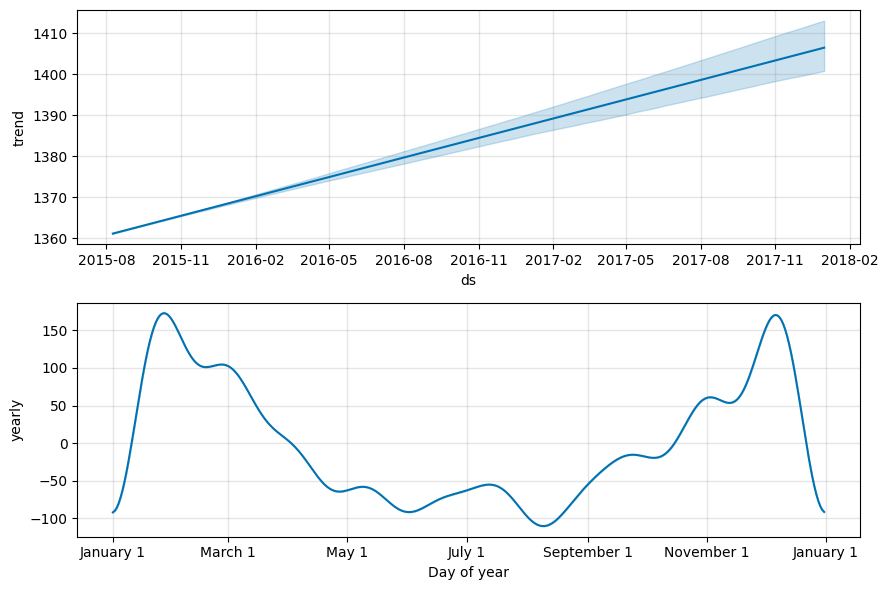

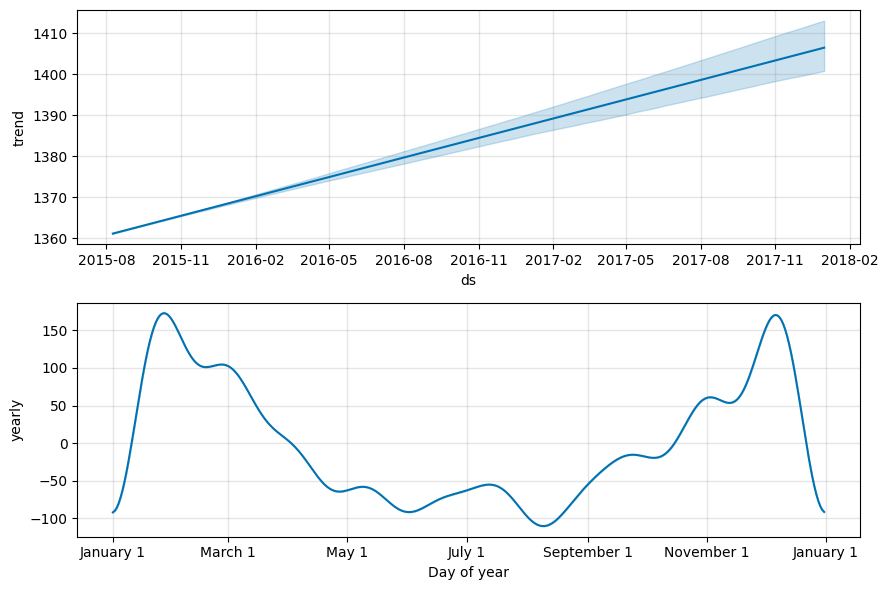

In [44]:
prophet_model.plot_components(forecast)

In [46]:
# Prepare data for Prophet
prophet_data = data.reset_index()
prophet_data.columns = ['ds', 'y']
len_test = len(test_data)

# Train Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.001)
prophet_model.fit(prophet_data[:-len_test])  # Train without test data

future = prophet_model.make_future_dataframe(periods=len_test, freq='D')  # Daily predictions
forecast = prophet_model.predict(future)

# Calculate MAE & RMSE
predicted = forecast['yhat'][-len_test:].values
actual = test_data['Consumption'].values
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Create interactive Plotly figure
fig = go.Figure()


# Actual test data
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['Consumption'],
    mode='lines',
    name='Actual Data',
    line=dict(color='blue')
))

# Predicted data
fig.add_trace(go.Scatter(
    x=forecast['ds'][-len_test:],
    y=forecast['yhat'][-len_test:],
    mode='lines',
    name='Predicted Data',
    line=dict(color='red', dash='dash')
))

#CI
fig.add_trace(go.Scatter(
    x=forecast['ds'][-len_test:].tolist() + forecast['ds'][-len_test:].tolist()[::-1],
    y=forecast['yhat_upper'][-len_test:].tolist() + forecast['yhat_lower'][-len_test:].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.6)',  # Darker pink with same transparency
    line=dict(color='rgba(255,255,255,0)'),
    name='Confidence Interval'
))


# Layout
fig.update_layout(
    title="Prophet: Daily Actual vs Predicted Consumption",
    xaxis_title="Date",
    yaxis_title="Power Consumption",
    legend=dict(x=0, y=1),
    hovermode="x",
    template="plotly_white"
)

split_point = prophet_data[:-len_test]['ds'].iloc[-1]
# Add a vertical dashed line at the split point
fig.add_vline(
    x=split_point,
    line=dict(color="black", dash="dash", width=2),
    name="Train-Test Split"
)

fig.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0mau9dn/g0yjqwa5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0mau9dn/05zy48pl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15410', 'data', 'file=/tmp/tmpj0mau9dn/g0yjqwa5.json', 'init=/tmp/tmpj0mau9dn/05zy48pl.json', 'output', 'file=/tmp/tmpj0mau9dn/prophet_modelz_wren_z/prophet_model-20250406193745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:37:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:37:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error (RMSE): 61.34


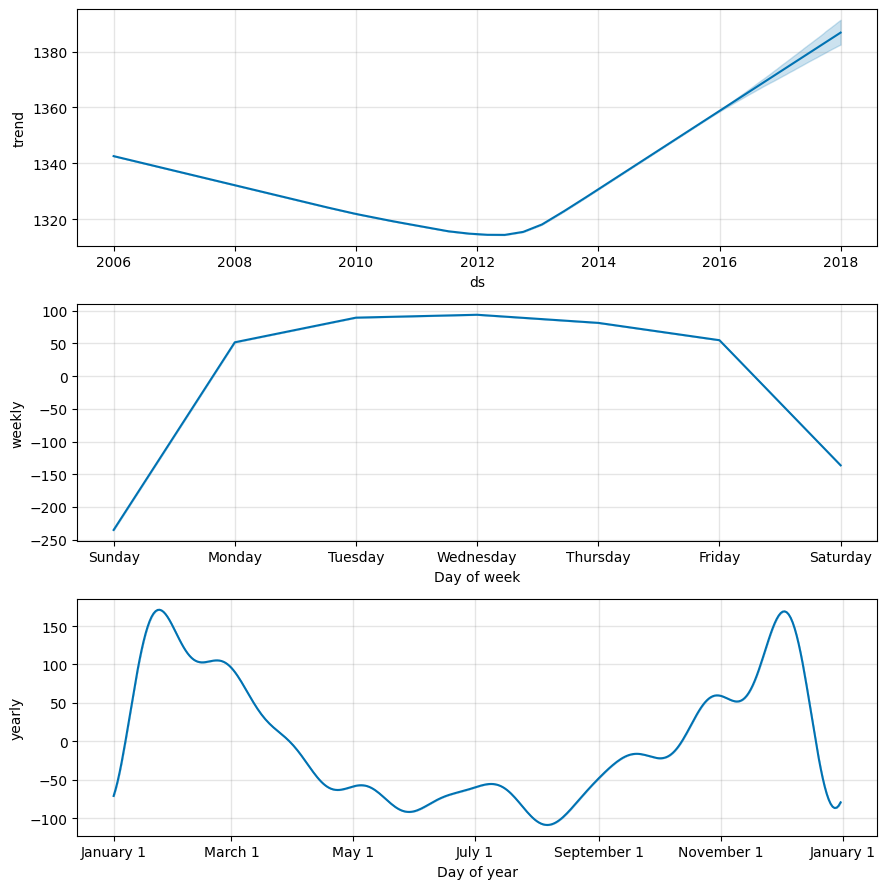

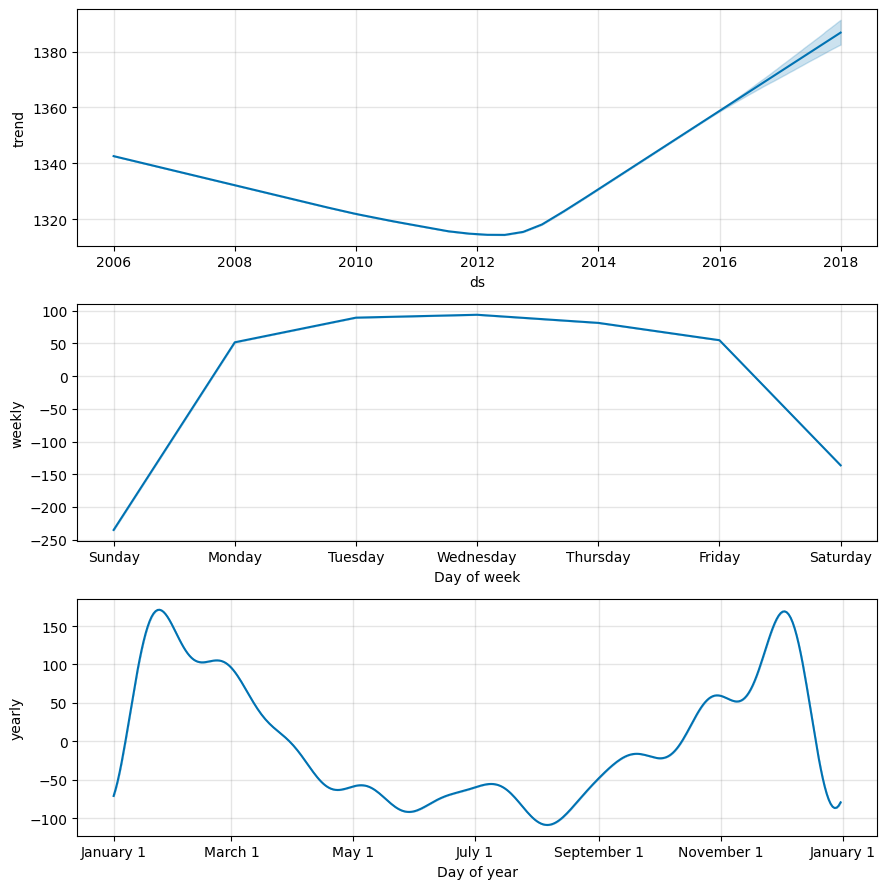

In [47]:
prophet_model.plot_components(forecast)

## Exponential Smoothing (Holt-Winters)

In [48]:
train_data = train_data['Consumption']
test_data = test_data['Consumption']
train_data

Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
                ...   
2015-08-03    1353.912
2015-08-04    1385.440
2015-08-05    1368.478
2015-08-06    1389.743
2015-08-07    1363.039
Name: Consumption, Length: 3506, dtype: float64

In [50]:
daily_series = data['Consumption']

In [54]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hw_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=365).fit()
forecast = hw_model.forecast(len(test_data))
# Evaluate performance
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"Holt-Winters Model RMSE: {rmse:.2f}")

# Create interactive Plotly figure
fig = go.Figure()

# Training data
fig.add_trace(go.Scatter(
    x=daily_series.index,
    y=daily_series.values,
    mode='lines',
    name='Actual Data',
    line=dict(color='blue')
))

# Forecast data
fig.add_trace(go.Scatter(
    x=test_data.index,
    y=forecast,
    mode='lines',
    name='Forecast',
    line=dict(color='red', dash='dash')
))

# Layout
fig.update_layout(
    title="Holt-Winters Model: Daily Actual vs Predicted Consumption",
    xaxis_title="Date",
    yaxis_title="Power Consumption",
    legend=dict(x=0, y=1),
    hovermode="x",
    template="plotly_white"
)
split_point = train_data.index[-1]
# Add a vertical dashed line at the split point
fig.add_vline(
    x=split_point,
    line=dict(color="black", dash="dash", width=2),
    name="Train-Test Split"
)
fig.show()


Holt-Winters Model RMSE: 150.71


In [57]:
hw_model = ExponentialSmoothing(train_weekly, seasonal='add', seasonal_periods=52).fit()
forecast = hw_model.forecast(len(test_weekly))

rmse = np.sqrt(mean_squared_error(test_weekly, forecast))
print(f"Holt-Winters Model RMSE: {rmse:.2f}")

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_series.index,
    y=weekly_series,
    mode='lines',
    name='Actual Data',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=test_weekly.index,
    y=forecast,
    mode='lines',
    name='Forecast',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title="Holt-Winters Model: Weekly Actual vs Predicted Consumption",
    xaxis_title="Date",
    yaxis_title="Power Consumption",
    legend=dict(x=0, y=1),
    hovermode="x",
    template="plotly_white"
)
split_point = train_weekly.index[-1]
fig.add_vline(
    x=split_point,
    line=dict(color="black", dash="dash", width=2),
    name="Train-Test Split"
)
fig.show()


Holt-Winters Model RMSE: 50.39


## XGBoost

In [59]:
import xgboost as xgb
daily_series = data
# Add more features from the date
daily_series['day_of_week'] = daily_series.index.dayofweek
daily_series['month'] = daily_series.index.month
daily_series['day_of_year'] = daily_series.index.dayofyear
daily_series['year'] = daily_series.index.year

X = daily_series[['month', 'day_of_year', 'year', 'day_of_week']]  # More features
y = daily_series['Consumption']  # Correctly reference the 'Consumption' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Keep the order since it's time series data

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_series.index, y=daily_series['Consumption'], mode='lines', name='True Consumption', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred, mode='lines', name='Predicted Consumption', line=dict(color='red', dash='dot')))
fig.update_layout(
    title="XGBoost: Daily Actual vs Predicted Consumption",
    xaxis_title="Observation",
    yaxis_title="Consumption",
    legend_title="Legend"
)
split_point = X_train.index[-1]

fig.add_vline(
    x=split_point,
    line=dict(color="black", dash="dash", width=2),
    name="Train-Test Split"
)

fig.show()

Root Mean Squared Error: 56.17812708937783


In [60]:
train_weekly_df['year']=train_weekly_df.index.year
test_weekly_df['year']=test_weekly_df.index.year

X_train = train_weekly_df[['week', 'year']]
X_test = test_weekly_df[['week', 'year']]
y_train = train_weekly_df['Consumption']
y_test = test_weekly_df['Consumption']

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

# Step 4: Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

fig = go.Figure()
fig.add_trace(go.Scatter(x=weekly_series.index, y=weekly_series.values, mode='lines', name='True Consumption', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred, mode='lines', name='Predicted Consumption', line=dict(color='red', dash='dot')))

fig.update_layout(
    title="XGBoost - Weekly Actual vs Predicted Consumption",
    xaxis_title="Observation",
    yaxis_title="Consumption",
    legend_title="Legend"
)
split_point = X_train.index[-1]

fig.add_vline(
    x=split_point,
    line=dict(color="black", dash="dash", width=2),
    name="Train-Test Split"
)

fig.show()


Root Mean Squared Error: 45.030764307345045


# **Part 3 - Incorporating an Exogenous Variable**

Exogenous Variable - average temperature on this day in Germany

In [61]:
data['DayType'] = data.index.dayofweek.map(lambda x: 'Weekday' if x < 5 else 'Weekend')

color_map = {'Weekday': 'blue', 'Weekend': 'red'}

fig = go.Figure()

for day_type in ['Weekday', 'Weekend']:
    subset = data[data['DayType'] == day_type]
    fig.add_trace(go.Scatter(
        x=subset.index,
        y=subset['Consumption'],
        mode='markers',
        name=day_type,
        marker=dict(color=color_map[day_type], size=4, opacity=0.6)
    ))

fig.update_layout(
    title="Power Consumption Over Time (Weekday vs. Weekend)",
    xaxis_title="Date",
    yaxis_title="Power Consumption (GWh)",
    hovermode="x unified",
    legend_title="Day Type"
)

fig.show()


In [62]:
temperature = pd.read_csv('daily_temperature.csv', index_col='date')
temperature

temperature(°C)
date                       
2006-01-01         2.537500
2006-01-02         1.537500
2006-01-03         1.270833
2006-01-04         0.029167
2006-01-05         0.908333
...                     ...
2017-12-28         2.466667
2017-12-29         0.016667
2017-12-30         5.687500
2017-12-31        10.783333
2018-01-01         7.191667

[4384 rows x 1 columns]

In [63]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=temperature.index,
    y=temperature['temperature(°C)'],
    mode='markers',  # Include markers to visualize the color change
    name='Temperature',
    marker=dict(
        color=temperature['temperature(°C)'],  # Color based on the temperature
        colorscale='Bluered',  # Use the 'Bluered' color scale
        size=5,  # Marker size
        colorbar=dict(
            title="Temperature (°C)",
            tickvals=[temperature['temperature(°C)'].min(), temperature['temperature(°C)'].max()],
        )
    )
))

fig.update_layout(
    title="Average Daily Temperature in Germany",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
)

fig.show()

In [64]:
temperature=temperature[:-1]
temperature

temperature(°C)
date                       
2006-01-01         2.537500
2006-01-02         1.537500
2006-01-03         1.270833
2006-01-04         0.029167
2006-01-05         0.908333
...                     ...
2017-12-27         3.537500
2017-12-28         2.466667
2017-12-29         0.016667
2017-12-30         5.687500
2017-12-31        10.783333

[4383 rows x 1 columns]

In [65]:
temperature.index = pd.to_datetime(temperature.index)

aligned_data = data.join(temperature.set_index(temperature.index))
aligned_data_clean = aligned_data.dropna()

correlation = aligned_data_clean['Consumption'].corr(aligned_data_clean['temperature(°C)'])
print(f"Correlation between Consumption and Temperature: {correlation:.2f}")

Correlation between Consumption and Temperature: -0.37


In [67]:
aligned_data.to_csv('power_consumption_data.csv')

In [68]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

temperature_scaled = scaler.fit_transform(aligned_data_clean[['temperature(°C)']])
consumption_scaled = scaler.fit_transform(aligned_data_clean[['Consumption']])

aligned_data_clean['temperature_scaled'] = temperature_scaled
aligned_data_clean['consumption_scaled'] = consumption_scaled

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=aligned_data_clean.index,
    y=aligned_data_clean['temperature_scaled'],
    mode='lines',
    name='Scaled Temperature',
    line=dict(color='blue'),
    opacity = 0.5
))

fig.add_trace(go.Scatter(
    x=aligned_data_clean.index,
    y=aligned_data_clean['consumption_scaled'],
    mode='lines',
    name='Scaled Consumption',
    line=dict(color='red'),
    opacity = 0.5
))

fig.update_layout(
    title="Scaled Temperature and Consumption Over Time",
    xaxis_title="Date",
    yaxis_title="Scaled Consumption",  # Left y-axis for Consumption
    yaxis2=dict(
        title="Scaled Temperature",  # Right y-axis for Temperature
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.01, y=0.99),
)

fig.show()


## Preparing Data

In [69]:
temperature_weekly = temperature.resample('W').mean()
temperature_weekly

temperature(°C)
date                       
2006-01-01         2.537500
2006-01-08         1.259524
2006-01-15        -2.213690
2006-01-22         0.917857
2006-01-29        -3.476786
...                     ...
2017-12-03         1.242262
2017-12-10         2.839286
2017-12-17         2.747619
2017-12-24         4.861310
2017-12-31         4.608929

[627 rows x 1 columns]

In [70]:
temperature_weekly = temperature.resample('W').mean()
temperature_weekly.head()

temperature(°C)
date                       
2006-01-01         2.537500
2006-01-08         1.259524
2006-01-15        -2.213690
2006-01-22         0.917857
2006-01-29        -3.476786

In [71]:
train_weekly = weekly_series[:int(len(weekly_series) * 0.8)]
test_weekly = weekly_series[int(len(weekly_series) * 0.8):]

In [72]:
train_weekly_df = train_weekly_df.merge(temperature_weekly[['temperature(°C)']], left_index=True, right_index=True, how='left')
test_weekly_df= test_weekly_df.merge(temperature_weekly[['temperature(°C)']], left_index=True, right_index=True, how='left')

## Prophet

In [73]:
# Merge to ensure alignment
weekly_df = weekly_series.to_frame()
prophet_data = weekly_df.merge(temperature_weekly, left_index=True, right_index=True)
prophet_data.reset_index(inplace=True)
# Rename columns correctly
prophet_data.rename(columns={"Consumption": "y", "Date": "ds"}, inplace=True)

# Ensure correct column order
prophet_data = prophet_data[['ds', 'y', 'temperature(°C)']]
prophet_data

ds            y  temperature(°C)
0   2006-01-01  1069.184000         2.537500
1   2006-01-08  1381.300143         1.259524
2   2006-01-15  1486.730286        -2.213690
3   2006-01-22  1490.031143         0.917857
4   2006-01-29  1514.176857        -3.476786
..         ...          ...              ...
622 2017-12-03  1536.236314         1.242262
623 2017-12-10  1554.824946         2.839286
624 2017-12-17  1543.856889         2.747619
625 2017-12-24  1440.342401         4.861310
626 2017-12-31  1203.265211         4.608929

[627 rows x 3 columns]

In [74]:
# Split into training and test sets
len_test = int(len(prophet_data) * 0.2)
prophet_data.columns = ['ds', 'y', 'temperature(°C)']

# Split the data into train and test
test = prophet_data[-len_test:].copy()
train = prophet_data[:-len_test].copy()

prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.005)
prophet_model.add_regressor('temperature(°C)')  # Add temperature as a regressor
prophet_model.fit(train)

future = test[['ds','temperature(°C)']].copy()
forecast = prophet_model.predict(future)

predicted = forecast['yhat'][-len_test:].values
actual = test['y'].values
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=prophet_data['ds'],
    y=prophet_data['y'],
    mode='lines',
    name='Actual Data',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=forecast['ds'][-len_test:],
    y=forecast['yhat'][-len_test:],
    mode='lines',
    name='Predicted Data',
    line=dict(color='red', dash='dot')
))

fig.add_trace(go.Scatter(
    x=forecast['ds'][-len_test:].tolist() + forecast['ds'][-len_test:].tolist()[::-1],
    y=forecast['yhat_upper'][-len_test:].tolist() + forecast['yhat_lower'][-len_test:].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.3)',  # Light pink
    line=dict(color='rgba(255,255,255,0)'),
    name='Confidence Interval'
))

fig.update_layout(
    title="Weekly Prophet with Exogenous Variable: Actual vs Predicted Consumption",
    xaxis_title="Date",
    yaxis_title="Power Consumption",
    legend=dict(x=0, y=1),
    hovermode="x",
    template="plotly_white"
)

split_point = train['ds'].iloc[-1]
fig.add_vline(
    x=split_point,
    line=dict(color="black", dash="dash", width=2),
    name="Train-Test Split"
)

fig.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0mau9dn/ucfj9p8o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0mau9dn/wzah28s4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70957', 'data', 'file=/tmp/tmpj0mau9dn/ucfj9p8o.json', 'init=/tmp/tmpj0mau9dn/wzah28s4.json', 'output', 'file=/tmp/tmpj0mau9dn/prophet_modelzx2l2ab3/prophet_model-20250406193907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error (RMSE): 42.28


In [75]:
prophet_data_daily = aligned_data.reset_index()[['Date', 'Consumption', 'temperature(°C)']]
prophet_data_daily.columns = ['ds', 'y', 'temperature']
train_size = int(len(daily_series) * 0.8)
train, test = daily_series[:train_size], daily_series[train_size:]
len_test = len(test)
test = prophet_data_daily[-len_test:].copy()
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.001)
prophet_model.add_regressor('temperature')  # Add temperature as a regressor
prophet_model.fit(prophet_data_daily[:-len_test])
future = test[['ds', 'temperature']].copy()
forecast = prophet_model.predict(future)

predicted = forecast['yhat'].values
actual = test['y'].values
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=daily_series.index,
    y=daily_series['Consumption'],
    mode='lines',
    name='Actual Data',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    name='Predicted Data',
    line=dict(color='red', dash='dash')
))
fig.add_trace(go.Scatter(
    x=forecast['ds'].tolist() + forecast['ds'].tolist()[::-1],
    y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.6)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Confidence Interval'
))
fig.update_layout(
    title="Daily Prophet with Exogenous Variable: Actual vs Predicted Consumption",
    xaxis_title="Date",
    yaxis_title="Power Consumption",
    legend=dict(x=0, y=1),
    hovermode="x",
    template="plotly_white"
)
split_point = train.index[-1]
fig.add_vline(
    x=split_point,
    line=dict(color="black", dash="dash", width=2),
    name="Train-Test Split"
)

fig.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0mau9dn/pmkjbhfy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0mau9dn/km8y7b_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56985', 'data', 'file=/tmp/tmpj0mau9dn/pmkjbhfy.json', 'init=/tmp/tmpj0mau9dn/km8y7b_c.json', 'output', 'file=/tmp/tmpj0mau9dn/prophet_modelt27xflh_/prophet_model-20250406193908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:39:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:39:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error (RMSE): 60.73


## SARIMA

In [76]:
model = SARIMAX(train_weekly_df['Consumption'],
                exog=train_weekly_df['temperature(°C)'],
                order=(1, 1, 1),              # Non-seasonal components (p,d,q)
                seasonal_order=(2, 0, 2, 52),  # Seasonal components (P,D,Q,s) for weekly
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit(disp=False)
print(results.summary())



                                        SARIMAX Results                                        
Dep. Variable:                             Consumption   No. Observations:                  501
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 52)   Log Likelihood               -2004.786
Date:                                 Sun, 06 Apr 2025   AIC                           4025.572
Time:                                         19:40:49   BIC                           4057.383
Sample:                                     01-01-2006   HQIC                          4038.177
                                          - 08-02-2015                                         
Covariance Type:                                   opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
temperature(°C)    -3.0419      0.534     -5.694      0.000     

In [77]:
test_steps = len(test_weekly_df)
test_forecast = results.get_forecast(steps=test_steps, exog=test_weekly_df[['temperature(°C)']])
test_ci = test_forecast.conf_int()
rmse = np.sqrt(mean_squared_error(test_weekly_df['Consumption'], test_forecast.predicted_mean))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=weekly_series.index, y=weekly_series.values,
                         mode='lines', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=test_weekly_df.index, y=test_forecast.predicted_mean,
                         mode='lines', name='SARIMA+temp Test Forecast', line=dict(color='red')))
fig.add_trace(go.Scatter(x=test_weekly_df.index, y=sarima_test_forecast.predicted_mean,
                         mode='lines', name='SARIMA Test Forecast', line=dict(color='pink')))
fig.add_trace(go.Scatter(x=[test_weekly_df.index[0], test_weekly_df.index[0]],
                         y=[weekly_series.values.min(), weekly_series.values.max()],
                         mode="lines", line=dict(color="black", dash="dot"), name="Train/Test Split"))
fig.update_layout(title="SARIMA - Weekly True vs Predicted Consumption with Temperature",
                  xaxis_title="Date",
                  yaxis_title="Consumption",
                  template="plotly_white")
fig.show()



Root Mean Squared Error (RMSE): 44.71


## XGBoost

In [78]:
X = aligned_data[['month', 'day_of_year', 'year', 'day_of_week','temperature(°C)']]
y = aligned_data['Consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

fig = go.Figure()
fig.add_trace(go.Scatter(x=aligned_data.index, y=aligned_data['Consumption'], mode='lines', name='True Consumption', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred, mode='lines', name='Predicted Consumption', line=dict(color='red', dash='dot')))

fig.update_layout(
    title="XGBoost - Daily True vs Predicted Consumption with Temperature",
    xaxis_title="Date",
    yaxis_title="Consumption",
    legend_title="Legend"
)
fig.add_vline(x=X_train.index[-1], line=dict(color="black", dash="dash", width=2), name="Train/Test Split")

fig.show()


Root Mean Squared Error: 59.459514169654625


In [79]:
X_train = train_weekly_df[['week', 'year', 'temperature(°C)']]
y_train = train_weekly_df['Consumption']

X_test = test_weekly_df[['week', 'year', 'temperature(°C)']]
y_test = test_weekly_df['Consumption']

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Plot results using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=weekly_df.index, y=weekly_df['Consumption'], mode='lines', name='True Consumption', line=dict(color='blue')))
# Predicted weekly consumption
fig.add_trace(go.Scatter(x=test_weekly.index, y=y_pred, mode='lines', name='Predicted Consumption', line=dict(color='red', dash='dot')))

# Layout settings
fig.update_layout(
    title="XGBoost - Weekly True vs Predicted Consumption with Temperature",
    xaxis_title="Date",
    yaxis_title="Consumption",
    legend_title="Legend",
    template="plotly_white"
)

fig.show()


Root Mean Squared Error (RMSE): 39.79


# **Part 4 - Change-Point Detection**

## Shewhart Chart

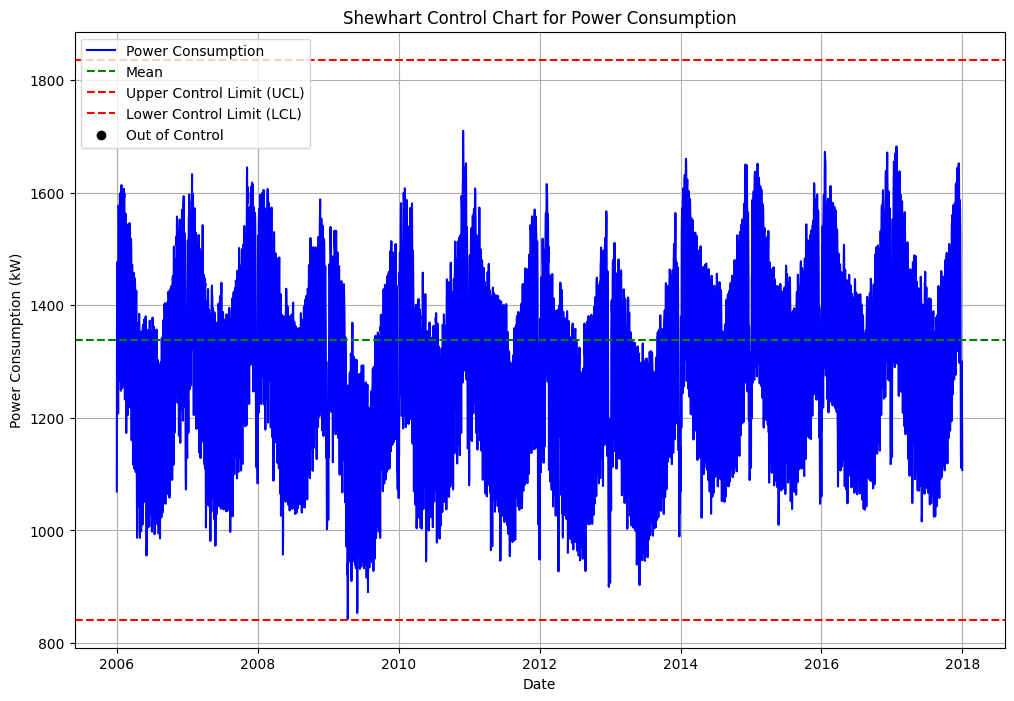

In [80]:
series = data['Consumption']

mean_val = series.mean()
std_dev = series.std()

UCL = mean_val + 3 * std_dev  # Upper Control Limit
LCL = mean_val - 3 * std_dev  # Lower Control Limit

plt.figure(figsize=(12, 8))
plt.plot(series, label='Power Consumption', color='blue')
plt.axhline(mean_val, color='green', linestyle='--', label='Mean')
plt.axhline(UCL, color='red', linestyle='--', label='Upper Control Limit (UCL)')
plt.axhline(LCL, color='red', linestyle='--', label='Lower Control Limit (LCL)')

out_of_control = series[(series > UCL) | (series < LCL)]
plt.scatter(out_of_control.index, out_of_control, color='black', label='Out of Control', zorder=3)

# Customize the plot
plt.title("Shewhart Control Chart for Power Consumption")
plt.xlabel("Date")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.grid(True)
plt.show()


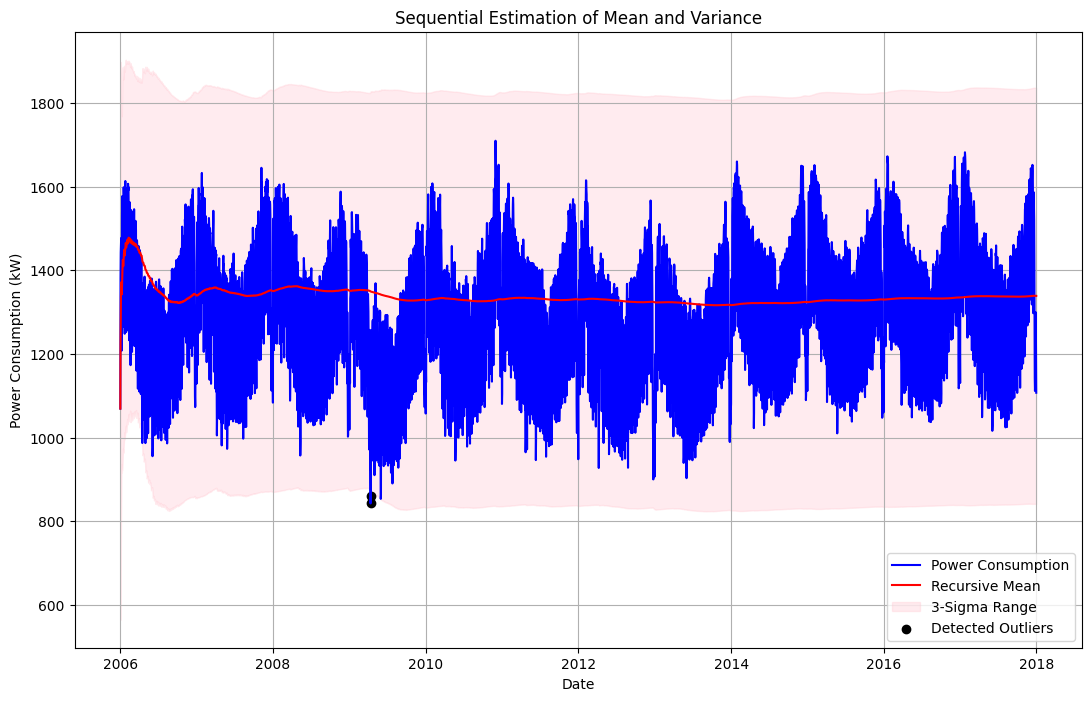

Detected Outliers Dates:
2009-04-12 00:00:00
2009-04-13 00:00:00


In [81]:
n = len(series)
mu_t = np.zeros(n)  # Running mean
s_t = np.zeros(n)  # Running variance
outliers = []

mu_t[0] = series.iloc[0]
s_t[0] = 0

for t in range(1, n):
    mu_t[t] = mu_t[t - 1] + (series.iloc[t] - mu_t[t - 1]) / (t + 1)
    s_t[t] = ((t - 1) * s_t[t - 1] + (series.iloc[t] - mu_t[t - 1]) * (series.iloc[t] - mu_t[t])) / t

    # Outlier detection
    if np.abs(series.iloc[t] - mu_t[t]) > 3 * np.sqrt(s_t[t]):
        outliers.append(series.index[t])


plt.figure(figsize=(13, 8))
plt.plot(series.index, series, label="Power Consumption", color="blue")
plt.plot(series.index, mu_t, label="Recursive Mean", color="red")
plt.fill_between(series.index, mu_t - 3 * np.sqrt(s_t), mu_t + 3 * np.sqrt(s_t), color="pink", alpha=0.3, label="3-Sigma Range")
plt.scatter(outliers, series.loc[outliers], color="black", marker="o", label="Detected Outliers")
plt.title("Sequential Estimation of Mean and Variance")
plt.xlabel("Date")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.grid()
plt.show()

print("Detected Outliers Dates:")
for date in outliers:
    print(date)


## CUSUM

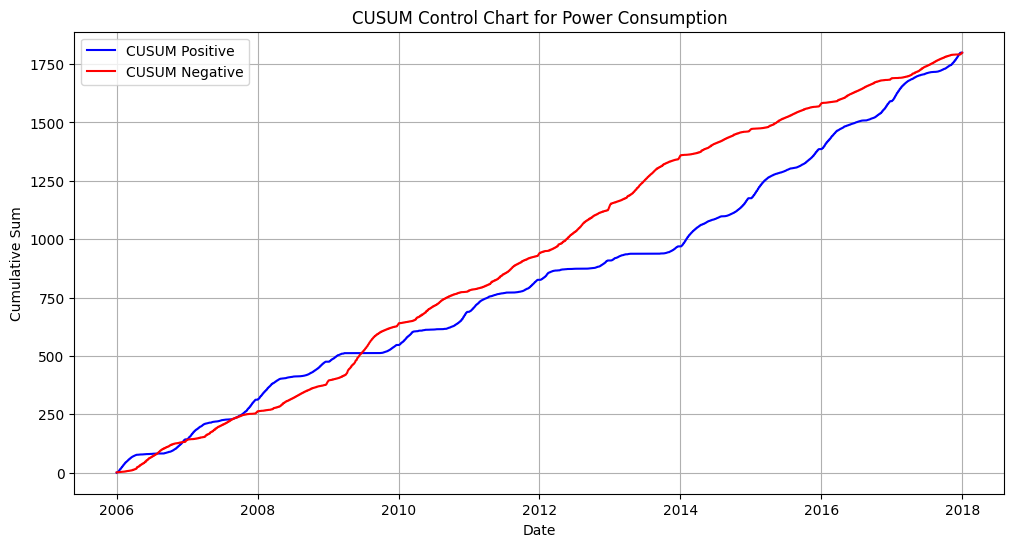

In [82]:
cusum_positive = np.maximum(0, (series - mean_val) / std_dev).cumsum()
cusum_negative = np.maximum(0, (mean_val - series) / std_dev).cumsum()

# Plot the CUSUM Control Chart
plt.figure(figsize=(12, 6))
plt.plot(series.index, cusum_positive, label='CUSUM Positive', color='blue')
plt.plot(series.index, cusum_negative, label='CUSUM Negative', color='red')

plt.title("CUSUM Control Chart for Power Consumption")
plt.xlabel("Date")
plt.ylabel("Cumulative Sum")
plt.legend()
plt.grid(True)
plt.show()


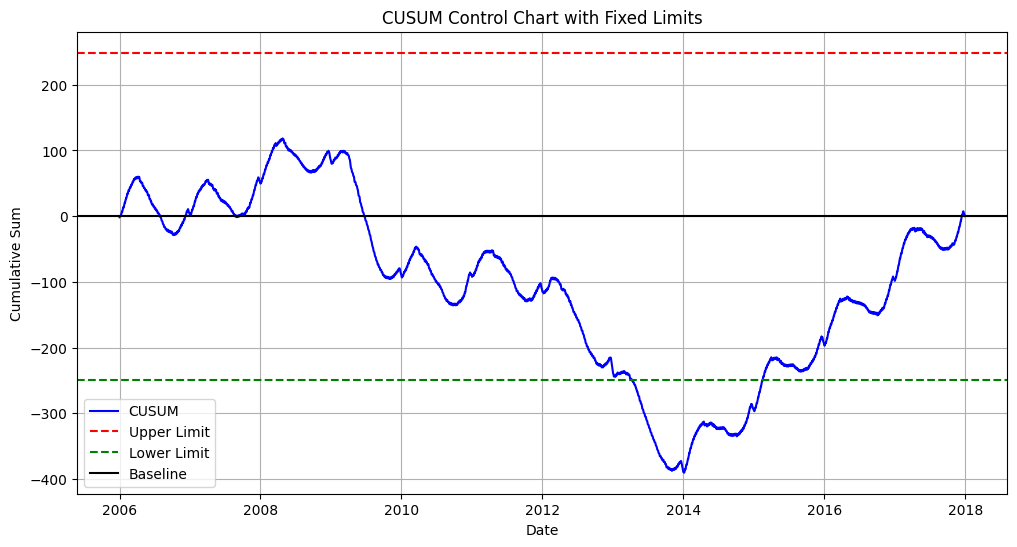

248.66356535218685


In [83]:
cusum = (series - mean_val) / std_dev
cusum_sum = cusum.cumsum()

upper_limit = 1.5 * std_dev
lower_limit = -1.5 * std_dev

# Plot CUSUM Control Chart
plt.figure(figsize=(12, 6))
plt.plot(series.index, cusum_sum, label='CUSUM', color='blue')
plt.axhline(y=upper_limit, color='red', linestyle='--', label='Upper Limit')
plt.axhline(y=lower_limit, color='green', linestyle='--', label='Lower Limit')
plt.axhline(y=0, color='black', linestyle='-', label='Baseline')

plt.title("CUSUM Control Chart with Fixed Limits")
plt.xlabel("Date")
plt.ylabel("Cumulative Sum")
plt.legend()
plt.grid(True)
plt.show()
print(upper_limit)

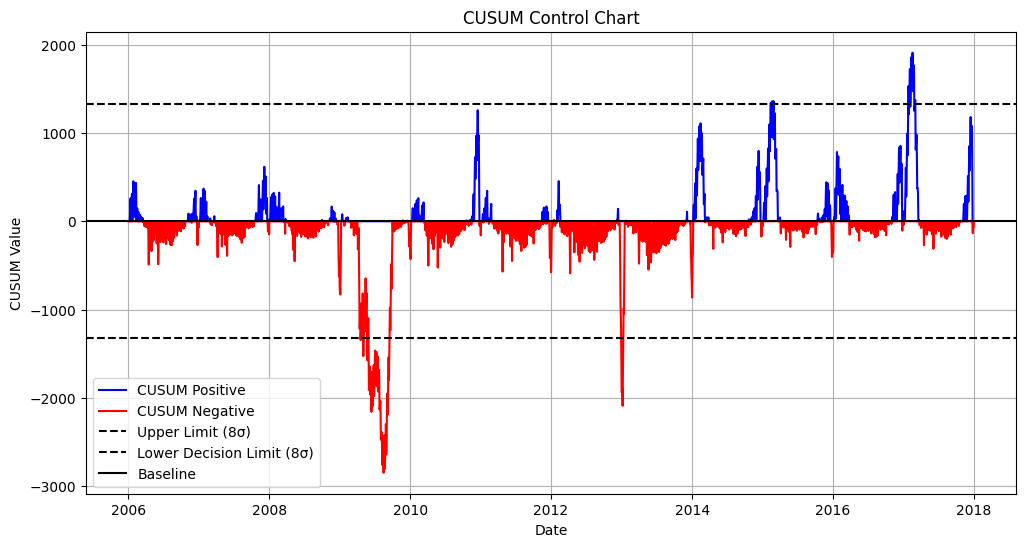

In [84]:
# Define CUSUM parameters
k = 1 * std_dev
h = 8 * std_dev

cusum_positive = np.zeros(len(series))
cusum_negative = np.zeros(len(series))

for t in range(1, len(series)):
    cusum_positive[t] = max(0, cusum_positive[t - 1] + (series.iloc[t] - mean_val - k))
    cusum_negative[t] = min(0, cusum_negative[t - 1] + (series.iloc[t] - mean_val + k))

upper_limit = h
lower_limit = -h

plt.figure(figsize=(12, 6))
plt.plot(series.index, cusum_positive, label='CUSUM Positive', color='blue')
plt.plot(series.index, cusum_negative, label='CUSUM Negative', color='red')
plt.axhline(y=upper_limit, color='black', linestyle='--', label='Upper Limit (8σ)')
plt.axhline(y=lower_limit, color='black', linestyle='--', label='Lower Decision Limit (8σ)')
plt.axhline(y=0, color='black', linestyle='-', label='Baseline')

plt.title("CUSUM Control Chart")
plt.xlabel("Date")
plt.ylabel("CUSUM Value")
plt.legend()
plt.grid(True)
plt.show()

